In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pylab

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Hyperparameter
batch_size = 25
z_dim = 128
learning_rate_gen = 9e-5
learning_rate_dis = 9e-5
max_step = 20000
n_dis = 5
# lambda (gradient panelty)
lam = 20.

from data_utils_batch import *
data_X = labelDataReader('../data/animate_label_twingan/')
batch_x, batch_y = data_X.next_batch(100)
f_dim = batch_y.shape[1]
print ('label dimension:', f_dim)
print ('data range:', np.max(batch_x), np.min(batch_x))

kernel_init = tf.random_normal_initializer(stddev = 0.02)

reload = True
reload_dir = '../model_2018_11_29/cgan-{}'
reload_epoch = 0 if not reload else 116000
print (reload_epoch)

label dimension: 51
data range: 0.32220891869149304 -0.7596269875073646
116000


In [3]:
def residual_block(x, filters = 64):
    conv1 = tf.layers.conv2d(x, 
                             filters = filters,
                             kernel_size = 3,
                             strides = 1,
                             padding = 'same',
                             kernel_initializer = kernel_init)
    conv1 = tf.layers.batch_normalization(conv1)
    conv1 = tf.nn.relu(conv1)
    
    conv2 = tf.layers.conv2d(conv1,
                             filters = filters,
                             kernel_size = 3,
                             strides = 1,
                             padding = 'same',
                             kernel_initializer = kernel_init)
    conv2 = tf.layers.batch_normalization(conv2)
    conv2 = tf.nn.relu(conv2)
    
    return tf.add(x, conv2)

def pixel_shuffle(I, r):
    bsize, a, b, c = I.get_shape().as_list()
    X = tf.reshape(I, (-1, a, b, r, r))
    X = tf.split(X, a, 1)  # a, [bsize, b, r, r]
    X = tf.concat([tf.squeeze(x) for x in X], 2)  # bsize, b, a*r, r
    X = tf.split(X, b, 1)  # b, [bsize, a*r, r]
    X = tf.concat([tf.squeeze(x) for x in X], 2)  # bsize, a*r, b*r
    return tf.reshape(X, (-1, a*r, b*r, 1))

def PS(X, r):
    X = tf.layers.conv2d(X,
                         filters = 64,
                         kernel_size = 3,
                         strides = 1,
                         padding = 'same',
                         kernel_initializer = kernel_init,
                         activation = tf.nn.relu)
    X = tf.layers.conv2d(X,
                         filters = 64,
                         kernel_size = 3,
                         strides = 1,
                         padding = 'same',
                         kernel_initializer = kernel_init,
                         activation = tf.nn.relu)
    Xc = tf.split(X, X.get_shape()[3] // (r ** 2), 3)
    X = tf.concat([pixel_shuffle(x, r) for x in Xc], 3)
    return X

def resize_block(x, filters):
    out = tf.layers.conv2d(x,
                           filters = filters,
                           kernel_size = 3,
                           strides = 1,
                           padding = 'same',
                           kernel_initializer = kernel_init)
    out = PS(out, 2)
    out = tf.layers.batch_normalization(out)
    return tf.nn.relu(out)

In [4]:
# Define Generator Network
def generator(x, label, reuse = False):
    with tf.variable_scope('generator', reuse = reuse):
        data = tf.concat([x, label], axis = 1)
        fc1 = tf.layers.dense(data, 
                              units = 6 * 6 * 256, 
                              activation = tf.nn.leaky_relu,
                              kernel_initializer = kernel_init)
        fc1 = tf.layers.batch_normalization(fc1)
        fc1 = tf.reshape(fc1, [-1, 6, 6, 256])

        # First Convolutional Layer
        conv1 = tf.layers.conv2d_transpose(fc1, 
                                           filters = 128, 
                                           kernel_size = 5,
                                           strides = 2,
                                           padding = 'same',
                                           activation = tf.nn.leaky_relu,
                                           kernel_initializer = kernel_init)
        conv1 = tf.layers.batch_normalization(conv1)

        res_blocks = []
        res_blocks.append(conv1)
        for i in range(4):
            res_blocks.append(residual_block(res_blocks[i], filters = 128))
            
            
        resize1 = resize_block(res_blocks[-1], filters = 128)
        resize2 = resize_block(resize1, filters = 128)
        resize3 = resize_block(resize2, filters = 128)
        
        # Third Convolutional Layer (Output Layer with tanh activation)
        output = tf.layers.conv2d_transpose(resize3, 
                                            filters = 3, 
                                            kernel_size = 9, 
                                            strides = 1,
                                            padding = 'same',
                                            activation = tf.nn.tanh,
                                            kernel_initializer = kernel_init)
        return output

# test
# z_input = tf.placeholder(tf.float32, shape = [None, z_dim], name = 'gen_input')
# generator(z_input)

In [5]:
def discriminator(x, label, reuse = False):
    with tf.variable_scope('discriminator', reuse = reuse):
        
        # conv1: 48 * 48 * 64
        conv1 = tf.layers.conv2d(x,
                                 filters = 64,
                                 kernel_size = 5,
                                 strides = 2,
                                 padding = 'same',
                                 activation = tf.nn.leaky_relu)
        conv1 = tf.layers.batch_normalization(conv1)
        
        
        # conv2: 24 * 24 * 64
        conv2 = tf.layers.conv2d(conv1,
                                 filters = 64,
                                 kernel_size = 5,
                                 strides = 2,
                                 padding = 'same',
                                 activation = tf.nn.leaky_relu)
        conv2 = tf.layers.batch_normalization(conv2)
        
        # Residual Blocks
        res1 = residual_block(conv2, filters = 64)
        res2 = residual_block(res1, filters = 64)
        # res3 = residual_block(res2, filters = 64)
        
        # conv3: 12 * 12 * 64
        conv3 = tf.layers.conv2d(res2,
                                 filters = 64,
                                 kernel_size = 5,
                                 strides = 2,
                                 padding = 'same',
                                 activation = tf.nn.leaky_relu)
        
        conv3 = tf.layers.batch_normalization(conv3)
        
        # res3_1 = residual_block(conv3, filters = 64)
        # res3_2 = residual_block(res3_1, filters = 64)
        
        
        
        
        
        res3 = tf.layers.flatten(conv3)
        x_flatten = tf.layers.flatten(x)
        conv2_flatten = tf.layers.flatten(conv2)
        res3 = tf.concat([res3, x_flatten, conv2_flatten, label], axis = 1)
        # res3 = tf.concat([res3, label], axis = 1)
        
        # fc1: 128 units
        fc1 = tf.layers.dense(res3, 
                              units = 128,
                              activation = tf.nn.leaky_relu)
        output = tf.layers.dense(fc1,
                                units = 1)
        return output

In [6]:
# Input
gen_input = tf.placeholder(tf.float32, shape = [None, z_dim - f_dim], name = 'gen_input')
dis_input = tf.placeholder(tf.float32, shape = [None, 96, 96, 3], name = 'dis_input')
lab_input = tf.placeholder(tf.float32, shape = [None, f_dim], name = 'lab_label')
fake_lab_input = tf.placeholder(tf.float32, shape = [None, f_dim], name = 'fake_lab_label')
fake_input = generator(gen_input, lab_input)

# Logits
true_logit = discriminator(dis_input, lab_input)
fake_logit = discriminator(fake_input, lab_input, reuse = True)
negative_logit_1 = discriminator(dis_input, fake_lab_input, reuse = True)
# negative_logit_2 = discriminator(fake_input, fake_lab_input, reuse = True)
# dis_loss = tf.reduce_mean(fake_logit - 2 * true_logit + negative_logit_1)
dis_loss = tf.reduce_mean(1.5 * fake_logit - 2 * true_logit + 0.5 * negative_logit_1)
gen_loss = tf.reduce_mean(- fake_logit)

# Variables
gen_var = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator')
dis_var = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator')

## Gradient Penalty

# Generate Interpolated Samples
uniform_dist = tf.contrib.distributions.Uniform(low=0., high=1.)
alpha = uniform_dist.sample((batch_size, 1, 1, 1))
interpolated = dis_input + alpha * (fake_input - dis_input)

# Calculate Gradients
int_logit = discriminator(interpolated, lab_input, reuse = True)
gradients = tf.gradients(int_logit, [interpolated, ])[0]
gradients_l2 = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis = [1, 2, 3]))

# Panelty
gradient_penalty = lam * tf.reduce_mean(tf.square(gradients_l2 - 1.))
dis_loss += gradient_penalty

# Optimizer (RMSProp) RMSPropOptimizer
gen_opt = tf.train.AdamOptimizer(learning_rate_gen, beta1=0.5).minimize(gen_loss, var_list = gen_var)
dis_opt = tf.train.AdamOptimizer(learning_rate_dis, beta1=0.5).minimize(dis_loss, var_list = dis_var)

Instructions for updating:
Use the retry module or similar alternatives.


In [7]:
# Initialization
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(tf.global_variables_initializer())

model_dir = '../model_2018_11_29/'
saver = tf.train.Saver()

if reload:
    print ('reload model from {}'.format(reload_dir.format(reload_epoch)))
    saver = tf.train.import_meta_graph(reload_dir.format(reload_epoch) + '.meta')
    saver.restore(sess, reload_dir.format(reload_epoch))
    

reload model from ../model_2018_11_29/cgan-116000
INFO:tensorflow:Restoring parameters from ../model_2018_11_29/cgan-116000


In [8]:
def get_fake_label(batch_y, batch_y_fake):
    for i in range(batch_y.shape[0]):
        if np.array_equal(batch_y_fake[i], batch_y[i]):
            index = random.randint(0, batch_y.shape[0] - 1)
            while np.array_equal(batch_y_fake[i], batch_y[index]) and np.array_equal(batch_y_fake[i], batch_y_fake[index]):
                index = random.randint(0, batch_y.shape[0] - 1)
            if not np.array_equal(batch_y_fake[i], batch_y[index]):
                batch_y_fake[i] = batch_y[index]
            else:
                batch_y_fake[i] = batch_y_fake[index]

In [9]:
for i in range(reload_epoch, max_step * 10):
    
    if i < reload_epoch:
        continue
    
    for j in range(n_dis):
        batch_x, batch_y = data_X.next_batch(batch_size)
        _, batch_y_fake = data_X.next_batch(batch_size)
        get_fake_label(batch_y, batch_y_fake)
        z = np.random.normal(0., 1., size=[batch_size, z_dim - f_dim])
        
        feed_dict = {gen_input: z, dis_input: batch_x, lab_input:batch_y, fake_lab_input: batch_y_fake}
        sess.run([dis_opt], feed_dict = feed_dict)
        
    batch_x, batch_y = data_X.next_batch(batch_size)
    _, batch_y_fake = data_X.next_batch(batch_size)
    get_fake_label(batch_y, batch_y_fake)
    z = np.random.normal(0., 1., size=[batch_size, z_dim - f_dim])
    
    feed_dict = {gen_input: z, dis_input: batch_x, lab_input:batch_y, fake_lab_input:batch_y_fake}
    sess.run([gen_opt], feed_dict = feed_dict)
    
    if i % 400 == 0:
        
        batch_x, batch_y = data_X.next_batch(batch_size)
        _, batch_y_fake = data_X.next_batch(batch_size)
        get_fake_label(batch_y, batch_y_fake)
        z = np.random.normal(0., 1., size=[batch_size, z_dim - f_dim])
                    
        feed_dict = {gen_input: z, dis_input: batch_x, lab_input:batch_y, fake_lab_input: batch_y_fake}
        d_loss, g_loss, p = sess.run([dis_loss, gen_loss, gradient_penalty], feed_dict = feed_dict)
        
        print ('step {}: {}, {}, {}'.format(i, d_loss, g_loss, p))
        print ('step {}: {} (Objective)'.format(i, d_loss - p))
        saver.save(sess, model_dir + 'cgan', global_step = i)
        reload_epoch = i

step 106400: -18.411500930786133, -49.2280387878418, 3.937185764312744
step 106400: -22.34868621826172 (Objective)
step 106800: -12.552594184875488, -61.98249816894531, 0.7850882411003113
step 106800: -13.337682723999023 (Objective)
step 107200: -8.978744506835938, -69.3440170288086, 1.4381283521652222
step 107200: -10.41687297821045 (Objective)
step 107600: 2.8547005653381348, -58.544307708740234, 7.909083366394043
step 107600: -5.054382801055908 (Objective)
step 108000: -23.70586395263672, -42.26081085205078, 2.792921304702759
step 108000: -26.4987850189209 (Objective)
step 108400: -25.14466094970703, -66.1441879272461, 2.7887179851531982
step 108400: -27.933378219604492 (Objective)
step 108800: 39.498043060302734, -36.218170166015625, 47.2645263671875
step 108800: -7.766483306884766 (Objective)
step 109200: -10.481249809265137, -73.67304992675781, 2.5745365619659424
step 109200: -13.0557861328125 (Objective)
step 109600: -12.621246337890625, -49.422607421875, 2.725917100906372
step 

KeyboardInterrupt: 

In [10]:
print (reload_epoch)

92000


In [10]:
rev_label_dict = {'long_hair': 0, 'short_hair': 1, 'blush': 2, 'smile': 3, 'blonde_hair': 4, 'blue_eyes': 5, 'brown_hair': 6, 'open_mouth': 7, 'hat': 8, 'red_eyes': 9, 'black_hair': 10, 'ribbon': 11, 'twintails': 12, 'brown_eyes': 13, 'blue_hair': 14, 'green_eyes': 15, 'purple_eyes': 16, 'pink_hair': 17, 'purple_hair': 18, 'closed_eyes': 19, 'ponytail': 20, 'green_hair': 21, 'simple_background': 22, 'red_hair': 23, 'yellow_eyes': 24, 'very_long_hair': 25, 'glasses': 26, 'silver_hair': 27, 'one_eye_closed': 28, 'ahoge': 29, 'male': 30, 'white_hair': 31, 'earrings': 32, 'tongue': 33, 'pink_eyes': 34, 'aqua_eyes': 35, 'black_eyes': 36, 'orange_hair': 37, 'aqua_hair': 38, 'grin': 39, 'multicolored_hair': 40, 'dark_skin': 41, 'tongue_out': 42, 'grey_hair': 43, 'drill_hair': 44, 'short_twintails': 45, 'orange_eyes': 46, 'facial_hair': 47, 'grey_eyes': 48, 'two-tone_hair': 49, 'tan': 50}
label_dict = {}
for key in rev_label_dict:
    label_dict[rev_label_dict[key]] = key

mean_rgb = np.array([172.83672573366928, 175.73611140584845, 193.70488181437796])
mean_rgb = mean_rgb / 255.

long_hair, smile, green_eyes, red_hair, 99.99571 0
long_hair, blush, black_hair, ribbon, purple_eyes, -27.782478 1
short_hair, blush, smile, blonde_hair, open_mouth, hat, closed_eyes, simple_background, 183.05565 2
long_hair, smile, blonde_hair, blue_eyes, 197.89998 3
long_hair, blush, smile, red_eyes, silver_hair, 82.97953 4
long_hair, blush, smile, pink_hair, simple_background, pink_eyes, 192.32819 5
short_hair, blue_eyes, blue_hair, -2.0362473 6
blue_eyes, green_hair, 22.31908 7
long_hair, smile, blonde_hair, blue_eyes, 199.07402 8
short_hair, smile, blue_eyes, brown_hair, 90.50591 9
long_hair, purple_eyes, pink_hair, 132.88594 10
blue_eyes, blue_hair, 8.171974 11
long_hair, blush, ribbon, twintails, purple_eyes, purple_hair, 19.992107 12
long_hair, smile, blonde_hair, blue_eyes, 198.03271 13
long_hair, smile, brown_hair, brown_eyes, simple_background, 94.45875 14
short_hair, blush, blue_eyes, brown_hair, hat, 73.97885 15
long_hair, red_eyes, red_hair, 73.29395 16
long_hair, blush, 

/home/shared/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


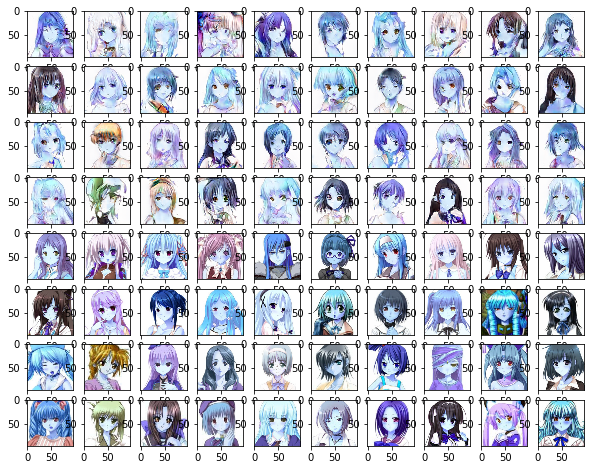

In [12]:
# Generate images from noise, using the generator network.
cnt = 0

f, a = plt.subplots(8, 10, figsize=(10, 8))
for i in range(10):
    # Noise input.
    
    
    batch_x, batch_y = data_X.next_batch(batch_size)
    
    batch_x = batch_x + mean_rgb
    
    # t_logit = sess.run([true_logit], feed_dict={dis_input: batch_x, lab_input: batch_y})
    # t_logit = np.reshape(t_logit, (batch_size, ))
    # print (t_logit)
    
    # print (f_logit.shape)
    for j in range(4):
        # Generate image from noise. Extend to 3 channels for matplot figure.
        
        z = np.random.normal(0., 1., size=[batch_size, z_dim - f_dim])
        
        batch_y_repeat = np.zeros((batch_size, f_dim))
        for k in range(batch_size):
            batch_y_repeat[k] = batch_y[j]
        
        g, f_logit = sess.run([fake_input, fake_logit], feed_dict={gen_input: z, lab_input: batch_y_repeat})
    
        g = g + mean_rgb
        g[g > 1.] = 1.
        g[g < 0.] = 0.
        
        
        f_logit = np.reshape(f_logit, (batch_size, ))
        index = np.argmax(f_logit)
        
        cv2.imwrite('../result/{}.jpg'.format(str(cnt).zfill(3)), g[index] * 255)
        
        img = g[index]
        np.flip(img, 2)
        a[j][i].imshow(img)
        img = batch_x[j]
        np.flip(img, 2)
        a[j + 4][i].imshow(img)
        cnt += 1
        
        for k in range(batch_y.shape[1]):
            if batch_y[j][k] == 1:
                print (label_dict[k], end = ', ')
        print (f_logit[index], cnt - 1)
f.show()
plt.draw()

short_hair, brown_hair, brown_eyes, simple_background, 0
long_hair, blush, smile, green_eyes, pink_hair, 1
short_hair, blush, smile, open_mouth, green_eyes, simple_background, silver_hair, 2
long_hair, smile, blonde_hair, blue_eyes, 3
long_hair, twintails, brown_eyes, blue_hair, 4
short_hair, blue_eyes, red_hair, 5
short_hair, brown_hair, brown_eyes, simple_background, 6
short_hair, smile, brown_hair, brown_eyes, simple_background, 7
long_hair, smile, ribbon, twintails, pink_hair, simple_background, pink_eyes, 8
short_hair, smile, red_eyes, blue_hair, simple_background, 9
long_hair, blush, red_eyes, blue_hair, 10
short_hair, red_eyes, pink_hair, 11
short_hair, smile, red_eyes, red_hair, 12
short_hair, blue_eyes, blue_hair, 13
long_hair, blonde_hair, blue_eyes, 14
long_hair, smile, blonde_hair, red_eyes, 15
short_hair, blue_eyes, green_hair, simple_background, 16
long_hair, red_eyes, blue_hair, 17
long_hair, smile, blue_eyes, brown_hair, 18
short_hair, blue_eyes, pink_hair, simple_backg

/home/shared/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


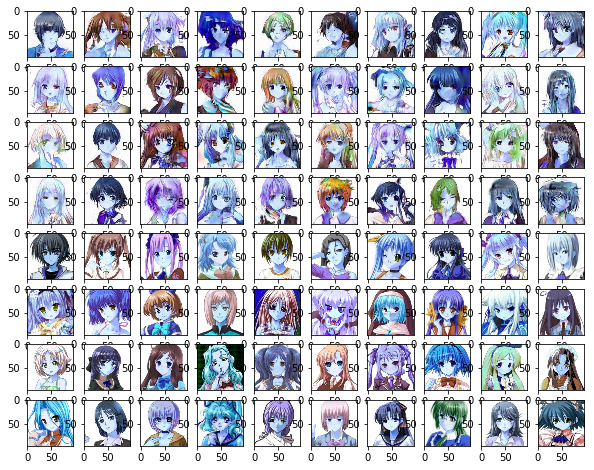

In [16]:
# Generate images from noise, using the generator network.
cnt = 0

f, a = plt.subplots(8, 10, figsize=(10, 8))
for i in range(10):
    # Noise input.
    z = np.random.normal(0., 1., size=[batch_size, z_dim - f_dim])
    
    batch_x, batch_y = data_X.next_batch(batch_size)
    
    batch_x = batch_x + mean_rgb
    
    g = sess.run(fake_input, feed_dict={gen_input: z, lab_input: batch_y})
    
    g = g + mean_rgb
    g[g > 1.] = 1.
    g[g < 0.] = 0.
        
    for j in range(4):
        # Generate image from noise. Extend to 3 channels for matplot figure.
        cv2.imwrite('../result/{}.jpg'.format(str(cnt).zfill(3)), g[j] * 255)
        cv2.imwrite('../result/{}.jpg'.format(str(cnt + 40).zfill(3)), batch_x[j] * 255)
        tmp = np.zeros((96, 96, 3))
        
        np.flip(g[j], 2)
        a[j][i].imshow(g[j])
        np.flip(batch_x[j], 2)
        a[j + 4][i].imshow(batch_x[j])
        cnt += 1
        
        for k in range(batch_y.shape[1]):
            if batch_y[j][k] == 1:
                print (label_dict[k], end = ', ')
        print (cnt - 1)
f.show()
plt.draw()

(8, 51)
(8, 96, 96, 3)
long_hair, blush, smile, red_eyes, pink_hair, glasses, 0
long_hair, blush, smile, red_eyes, pink_hair, glasses, 1
long_hair, blush, smile, red_eyes, pink_hair, glasses, 2
long_hair, blush, smile, red_eyes, pink_hair, glasses, 3
long_hair, blush, smile, red_eyes, pink_hair, glasses, 4
long_hair, blush, smile, red_eyes, pink_hair, glasses, 5
long_hair, blush, smile, red_eyes, pink_hair, glasses, 6
long_hair, blush, smile, red_eyes, pink_hair, glasses, 7
(8, 51)
(8, 96, 96, 3)
long_hair, red_eyes, ribbon, blue_hair, 8
long_hair, red_eyes, ribbon, blue_hair, 9
long_hair, red_eyes, ribbon, blue_hair, 10
long_hair, red_eyes, ribbon, blue_hair, 11
long_hair, red_eyes, ribbon, blue_hair, 12
long_hair, red_eyes, ribbon, blue_hair, 13
long_hair, red_eyes, ribbon, blue_hair, 14
long_hair, red_eyes, ribbon, blue_hair, 15
(8, 51)
(8, 96, 96, 3)
short_hair, blue_eyes, black_hair, simple_background, 16
short_hair, blue_eyes, black_hair, simple_background, 17
short_hair, blue_ey

/home/shared/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


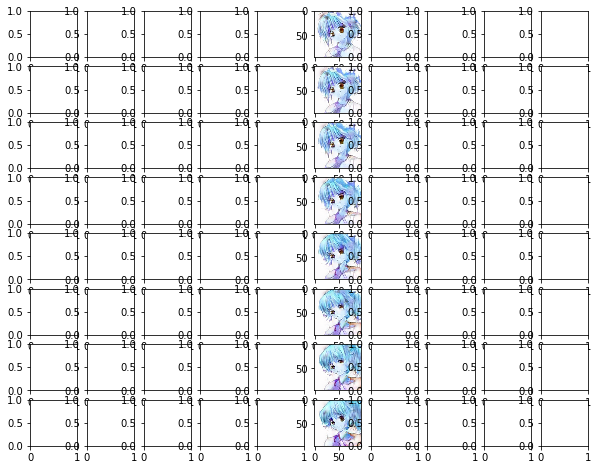

In [15]:
cnt = 0
f, a = plt.subplots(8, 10, figsize=(10, 8))
for i in range(5):
    # Noise input.
    z = np.random.normal(0., 1., size=[8, z_dim - f_dim])
    batch_x, batch_y = data_X.next_batch(1)
    
    batch_y = np.repeat(batch_y, 8, axis = 0)
    print (batch_y.shape)
    
    for i in range(6):
        z[i + 1] = (z[7] - z[0]) * ((i + 1) / 7.) + z[0]
    
    g = sess.run(fake_input, feed_dict={gen_input: z, lab_input: batch_y})
    
    g = g + mean_rgb
    g[g > 1.] = 1.
    g[g < 0.] = 0.
    print (g.shape)
    for j in range(8):
        
        cv2.imwrite('../result/{}.jpg'.format(str(cnt).zfill(3)), g[j] * 255)
        tmp = np.zeros((96, 96, 3))
        img = g[j]
        np.flip(img, 2)
        a[j][i].imshow(img)
        
        
        cnt += 1
        
        for k in range(batch_y.shape[1]):
            if batch_y[j][k] == 1:
                print (label_dict[k], end = ', ')
        print (cnt - 1)
f.show()
plt.draw()


long_hair, smile, purple_eyes, purple_hair, 21.999842 0
short_hair, red_eyes, blue_hair, simple_background, 2.7955189 1
long_hair, smile, black_hair, green_eyes, 18.453712 2
long_hair, blue_hair, yellow_eyes, 19.516405 3
long_hair, blush, black_hair, purple_eyes, 11.47678 4
long_hair, blush, blonde_hair, ribbon, yellow_eyes, 105.854 5
long_hair, brown_hair, brown_eyes, 68.201 6
short_hair, red_eyes, silver_hair, 33.90057 7
long_hair, blush, red_eyes, black_hair, 14.7488575 8
short_hair, smile, red_eyes, red_hair, 61.880093 9
short_hair, black_hair, purple_eyes, simple_background, -12.002567 10
short_hair, green_eyes, green_hair, 18.132965 11
long_hair, blush, smile, blue_eyes, twintails, pink_hair, 113.50519 12
short_hair, blush, smile, blue_eyes, red_hair, 71.53516 13
short_hair, blue_eyes, purple_hair, 9.624989 14
short_hair, black_hair, black_eyes, -14.72435 15
long_hair, blue_eyes, red_hair, 69.2166 16
short_hair, red_eyes, pink_hair, 71.74142 17
long_hair, blue_eyes, blue_hair, 18

/home/shared/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


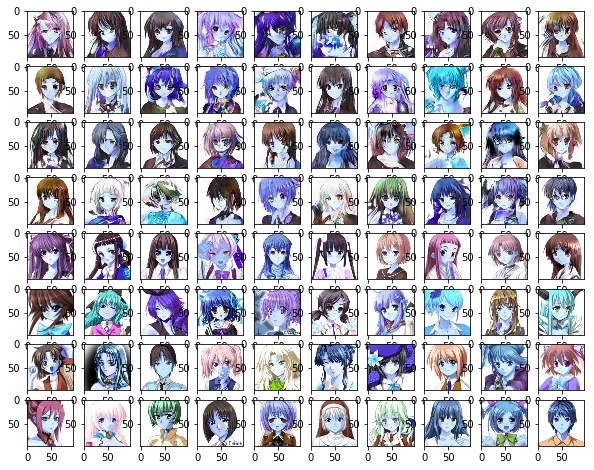

In [20]:
# Generate images from noise, using the generator network.
cnt = 0

f, a = plt.subplots(8, 10, figsize=(10, 8))
for i in range(10):
    # Noise input.
    
    batch_x, batch_y = data_X.next_batch(batch_size)
    
    batch_x = batch_x + mean_rgb
    
    # t_logit = sess.run([true_logit], feed_dict={dis_input: batch_x, lab_input: batch_y})
    # t_logit = np.reshape(t_logit, (batch_size, ))
    # print (t_logit)
    
    # print (f_logit.shape)
    for j in range(4):
        # Generate image from noise. Extend to 3 channels for matplot figure.
        
        z = np.random.normal(0., 1., size=[batch_size, z_dim - f_dim])
        
        batch_y_repeat = np.zeros((batch_size, f_dim))
        for k in range(batch_size):
            batch_y_repeat[k] = batch_y[j]
        
        g, f_logit = sess.run([fake_input, fake_logit], feed_dict={gen_input: z, lab_input: batch_y_repeat})
    
        g = g + mean_rgb
        g[g > 1.] = 1.
        g[g < 0.] = 0.
        
        
        f_logit = np.reshape(f_logit, (batch_size, ))
        index = np.argmax(f_logit)
        
        cv2.imwrite('../result/{}.jpg'.format(str(cnt).zfill(3)), g[index] * 255)
        
        img = g[index]
        np.flip(img, 2)
        a[j][i].imshow(img)
        img = batch_x[j]
        np.flip(img, 2)
        a[j + 4][i].imshow(img)
        cnt += 1
        
        for k in range(batch_y.shape[1]):
            if batch_y[j][k] == 1:
                print (label_dict[k], end = ', ')
        print (f_logit[index], cnt - 1)
f.show()
plt.draw()

58.6275
0 76.32222 67.181274
1 73.10149 13.260204
2 74.2053 86.599495
3 77.438705 -47.65802
4 68.470406 174.32141
5 70.612625 197.36113
6 83.03243 71.26158
7 82.87551 63.47099
8 63.749313 -17.937721
9 74.65442 68.01462
10 73.358086 -31.133614
11 80.54883 -6.6330643
12 76.65939 185.17986
13 76.87071 185.63538
14 76.736786 84.1673
15 67.26442 -13.029022
16 71.35614 76.454704
17 76.097855 71.686424
18 75.04382 -26.174011
19 70.35835 164.8669


/home/shared/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


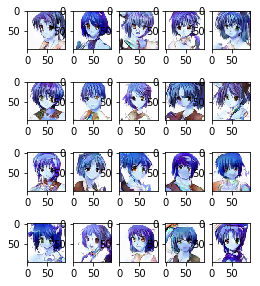

In [17]:
preset_condition = np.zeros((batch_size, 51))
preset_condition[:, rev_label_dict['short_hair']] = 1
preset_condition[:, rev_label_dict['blue_eyes']] = 1
# preset_condition[:, rev_label_dict['one_eye_closed']] = 1
preset_condition[:, rev_label_dict['red_hair']] = 1

f, a = plt.subplots(4, 5, figsize=(4, 5))
z = np.random.normal(0., 1., size=[batch_size, z_dim - f_dim])

batch_x, batch_y = data_X.next_batch(batch_size)

g, f_logit = sess.run([fake_input, fake_logit], feed_dict={gen_input: z, lab_input: preset_condition})

t_logit = sess.run([true_logit], feed_dict = {dis_input: batch_x, lab_input: batch_y})

t_logit = np.reshape(t_logit, (batch_size, ))
f_logit = np.reshape(f_logit, (batch_size, ))
g = g + mean_rgb
g[g > 1.] = 1.
g[g < 0.] = 0.

print (np.mean(t_logit))

for i in range(4):
    for j in range(5):
        cv2.imwrite('../result/{}.jpg'.format(str(i * 5 + j).zfill(3)), g[i * 5 + j] * 255)
        img = g[i * 5 + j]
        np.flip(img, 2)
        print (i * 5 + j, f_logit[i * 5 + j], t_logit[i * 5 + j])
        a[i][j].imshow(img)
        

f.show()
plt.draw()

In [ ]:
step 0: -26.79251480102539, 0.004090278875082731, 0.6825396418571472
step 0: -27.475053787231445 (Objective)
step 400: -44.39944076538086, -14.453638076782227, 20.60000991821289
step 400: -64.99945068359375 (Objective)
step 800: -24.96111297607422, -3.4247610569000244, 8.5035982131958
step 800: -33.4647102355957 (Objective)
step 1200: -26.049880981445312, -12.181396484375, 6.191994667053223
step 1200: -32.24187469482422 (Objective)
step 1600: -24.730039596557617, -4.317758083343506, 4.074525356292725
step 1600: -28.8045654296875 (Objective)
step 2000: -17.883411407470703, 0.48673510551452637, 1.9790458679199219
step 2000: -19.862457275390625 (Objective)
step 2400: -16.840957641601562, -6.438312530517578, 4.924036979675293
step 2400: -21.764995574951172 (Objective)
step 2800: -15.50246810913086, -7.002696514129639, 2.4633195400238037
step 2800: -17.965787887573242 (Objective)
step 3200: -22.661954879760742, -0.3277900815010071, 3.0100128650665283
step 3200: -25.671968460083008 (Objective)
step 3600: -15.020580291748047, -1.6580004692077637, 2.242452621459961
step 3600: -17.263032913208008 (Objective)
step 4000: -12.50539493560791, 6.788017749786377, 2.0646772384643555
step 4000: -14.570072174072266 (Objective)
step 4400: -14.955362319946289, -11.8343505859375, 2.957263469696045
step 4400: -17.912626266479492 (Objective)
step 4800: -13.92441177368164, -0.6694247722625732, 4.063614368438721
step 4800: -17.988025665283203 (Objective)
step 5200: -16.792949676513672, -4.2205939292907715, 2.3583288192749023
step 5200: -19.15127944946289 (Objective)
step 5600: -16.38302230834961, -1.8005732297897339, 2.2517924308776855
step 5600: -18.634815216064453 (Objective)
step 6000: -15.959306716918945, 0.7175186276435852, 2.5433542728424072
step 6000: -18.502660751342773 (Objective)
step 6400: -12.789587020874023, 0.8144972324371338, 2.0839056968688965
step 6400: -14.873493194580078 (Objective)
step 6800: -13.41684341430664, 1.9762989282608032, 2.2988474369049072
step 6800: -15.715690612792969 (Objective)
step 7200: -16.76905059814453, 7.221030235290527, 2.8420567512512207
step 7200: -19.611106872558594 (Objective)
step 7600: -10.622699737548828, -0.27713197469711304, 2.615501880645752
step 7600: -13.238201141357422 (Objective)
step 8000: -4.181448936462402, -12.152295112609863, 2.2906506061553955
step 8000: -6.472099304199219 (Objective)
step 8400: -15.80759334564209, -4.377622127532959, 1.4347599744796753
step 8400: -17.242353439331055 (Objective)
step 8800: -13.05608081817627, 4.854172706604004, 1.9377021789550781
step 8800: -14.993782997131348 (Objective)
step 9200: -11.672065734863281, -5.124163627624512, 1.7584426403045654
step 9200: -13.430508613586426 (Objective)
step 9600: -15.214499473571777, -8.618517875671387, 2.957259178161621
step 9600: -18.1717586517334 (Objective)
step 10000: -16.597238540649414, -5.530851364135742, 1.4880751371383667
step 10000: -18.08531379699707 (Objective)
step 10400: -15.166661262512207, 3.604738235473633, 2.1027896404266357
step 10400: -17.269451141357422 (Objective)
step 10800: -17.410465240478516, 3.4792542457580566, 2.4223814010620117
step 10800: -19.832847595214844 (Objective)
step 11200: -15.767168045043945, -4.21841287612915, 2.4348340034484863
step 11200: -18.202001571655273 (Objective)
step 11600: -14.906607627868652, -6.964335918426514, 3.387099504470825
step 11600: -18.2937068939209 (Objective)
step 12000: -10.345947265625, -13.192692756652832, 2.2635414600372314
step 12000: -12.609488487243652 (Objective)
step 12400: -14.919387817382812, 1.715854525566101, 2.127216339111328
step 12400: -17.04660415649414 (Objective)
step 12800: -13.130851745605469, -0.9808608293533325, 1.7981715202331543
step 12800: -14.929023742675781 (Objective)
step 13200: -12.835582733154297, -8.924776077270508, 2.033578395843506
step 13200: -14.869161605834961 (Objective)
step 13600: -14.921142578125, 4.920388698577881, 2.5294971466064453
step 13600: -17.450639724731445 (Objective)
step 14000: -12.151556015014648, -10.675065994262695, 1.51927649974823
step 14000: -13.670832633972168 (Objective)
step 14400: -5.6657490730285645, -2.7157182693481445, 1.8351203203201294
step 14400: -7.500869274139404 (Objective)
step 14800: -13.685551643371582, -5.431416034698486, 1.6560016870498657
step 14800: -15.341553688049316 (Objective)
step 15200: -11.164192199707031, -5.240182876586914, 2.3577075004577637
step 15200: -13.521900177001953 (Objective)
step 15600: -14.747655868530273, -14.550775527954102, 1.630102515220642
step 15600: -16.377758026123047 (Objective)
step 16000: -12.788768768310547, -3.8702328205108643, 1.7767833471298218
step 16000: -14.5655517578125 (Objective)
step 16400: -13.782175064086914, -15.382829666137695, 2.4574131965637207
step 16400: -16.239587783813477 (Objective)
step 16800: -14.697836875915527, -12.922450065612793, 1.126036524772644
step 16800: -15.823873519897461 (Objective)
step 17200: -11.205099105834961, -12.931406021118164, 1.5304793119430542
step 17200: -12.735578536987305 (Objective)
step 17600: -7.870538711547852, -13.193168640136719, 1.4070051908493042
step 17600: -9.277544021606445 (Objective)
step 18000: -17.969131469726562, -22.881454467773438, 2.2369167804718018
step 18000: -20.2060489654541 (Objective)
step 18400: -8.81800651550293, -3.0792477130889893, 2.491340160369873
step 18400: -11.309347152709961 (Objective)
step 18800: -11.186941146850586, -11.816747665405273, 1.9015085697174072
step 18800: -13.088449478149414 (Objective)
step 19200: -12.335043907165527, -6.622443199157715, 1.4976531267166138
step 19200: -13.832696914672852 (Objective)
step 19600: -10.709623336791992, -9.883646011352539, 1.4598546028137207
step 19600: -12.169477462768555 (Objective)
step 20000: -13.267906188964844, -15.37483024597168, 1.4568641185760498
step 20000: -14.724770545959473 (Objective)
step 20400: -14.259197235107422, -12.591943740844727, 2.4217967987060547
step 20400: -16.680994033813477 (Objective)
step 20800: -13.225432395935059, -12.602649688720703, 1.448010802268982
step 20800: -14.673442840576172 (Objective)
step 21200: -11.776385307312012, -20.2443904876709, 1.061775803565979
step 21200: -12.83816146850586 (Objective)
step 21600: -13.469573974609375, -17.215118408203125, 1.3534265756607056
step 21600: -14.82300090789795 (Objective)
step 22000: -9.899772644042969, -16.923809051513672, 1.2030904293060303
step 22000: -11.102863311767578 (Objective)
step 22400: -10.631409645080566, -20.284975051879883, 1.8178081512451172
step 22400: -12.449217796325684 (Objective)
step 22800: -11.974997520446777, -21.421552658081055, 1.8280608654022217
step 22800: -13.803058624267578 (Objective)
step 23200: -12.59145736694336, -26.393159866333008, 2.650568962097168
step 23200: -15.242026329040527 (Objective)
step 23600: -11.655791282653809, -20.919700622558594, 2.123065948486328
step 23600: -13.778857231140137 (Objective)
step 24000: -10.63807201385498, -17.77352523803711, 1.864965558052063
step 24000: -12.503037452697754 (Objective)
step 24400: -12.71410083770752, -16.181289672851562, 1.4047073125839233
step 24400: -14.118807792663574 (Objective)
step 24800: -14.488460540771484, -26.74987030029297, 1.8890434503555298
step 24800: -16.377504348754883 (Objective)
step 25200: -12.051189422607422, -23.15314483642578, 1.8375850915908813
step 25200: -13.888774871826172 (Objective)
step 25600: -11.84029769897461, -28.22723960876465, 1.0908399820327759
step 25600: -12.931138038635254 (Objective)
step 26000: -9.658846855163574, -24.449617385864258, 1.0003235340118408
step 26000: -10.659170150756836 (Objective)
step 26400: -15.003227233886719, -23.33411407470703, 1.001007318496704
step 26400: -16.004234313964844 (Objective)
step 26800: -9.733633041381836, -21.272876739501953, 1.9200645685195923
step 26800: -11.653697967529297 (Objective)
step 27200: -12.592504501342773, -20.727514266967773, 0.8556851744651794
step 27200: -13.448189735412598 (Objective)
step 27600: -13.02000617980957, -27.235641479492188, 1.3270008563995361
step 27600: -14.347006797790527 (Objective)
step 28000: -6.739194869995117, -17.098285675048828, 1.798135757446289
step 28000: -8.537330627441406 (Objective)
step 28400: -10.46393871307373, -26.69384002685547, 1.5411943197250366
step 28400: -12.005132675170898 (Objective)
step 28800: -11.63851261138916, -24.944141387939453, 1.7619884014129639
step 28800: -13.400501251220703 (Objective)
step 29200: -11.901515007019043, -29.40484046936035, 1.2302086353302002
step 29200: -13.131723403930664 (Objective)
step 29600: -11.468879699707031, -33.74116134643555, 1.1354563236236572
step 29600: -12.60433578491211 (Objective)
step 30000: -13.216917991638184, -25.298925399780273, 1.6476449966430664
step 30000: -14.86456298828125 (Objective)
step 30400: -10.922687530517578, -24.770828247070312, 1.9533886909484863
step 30400: -12.876075744628906 (Objective)
step 30800: -20.729999542236328, -30.083505630493164, 2.090129852294922
step 30800: -22.82012939453125 (Objective)
step 31200: -4.6791815757751465, -32.01020812988281, 2.0675559043884277
step 31200: -6.746737480163574 (Objective)
step 31600: -10.317359924316406, -24.191579818725586, 0.7608704566955566
step 31600: -11.078229904174805 (Objective)
step 32000: -6.3058037757873535, -23.609546661376953, 2.706695079803467
step 32000: -9.01249885559082 (Objective)
step 32400: -13.33664608001709, -32.202701568603516, 1.5249640941619873
step 32400: -14.861610412597656 (Objective)
step 32800: -9.018746376037598, -33.90565490722656, 1.6119486093521118
step 32800: -10.630695343017578 (Objective)
step 33200: -10.646255493164062, -22.922283172607422, 6.291385650634766
step 33200: -16.937641143798828 (Objective)
step 33600: -7.892260551452637, -39.660675048828125, 1.8324730396270752
step 33600: -9.724733352661133 (Objective)
step 34000: -17.070924758911133, -19.23430633544922, 2.320308208465576
step 34000: -19.391233444213867 (Objective)
step 34400: -12.129939079284668, -36.30799865722656, 1.263008713722229
step 34400: -13.392948150634766 (Objective)
step 34800: -3.765048027038574, -31.039018630981445, 3.33256196975708
step 34800: -7.097609996795654 (Objective)
step 35200: -11.007210731506348, -33.05461120605469, 2.9946982860565186
step 35200: -14.001909255981445 (Objective)
step 35600: -11.281113624572754, -28.2089900970459, 1.2961571216583252
step 35600: -12.5772705078125 (Objective)
step 36000: -15.529170036315918, -28.740293502807617, 0.9342947602272034
step 36000: -16.463464736938477 (Objective)
step 36400: -12.932767868041992, -31.1125545501709, 1.5696656703948975
step 36400: -14.502433776855469 (Objective)
step 36800: -12.638288497924805, -31.88150405883789, 1.3886399269104004
step 36800: -14.026927947998047 (Objective)
step 37200: -14.363910675048828, -35.75612258911133, 2.145826578140259
step 37200: -16.509737014770508 (Objective)
step 37600: -7.847044944763184, -30.15353775024414, 4.019285202026367
step 37600: -11.86633014678955 (Objective)
step 38000: -11.144906044006348, -45.22605895996094, 2.0809991359710693
step 38000: -13.225905418395996 (Objective)
step 38400: -15.056333541870117, -35.90030288696289, 2.846975564956665
step 38400: -17.903308868408203 (Objective)
step 38800: -20.563587188720703, -47.1197624206543, 1.2453194856643677
step 38800: -21.80890655517578 (Objective)
step 39200: -9.512626647949219, -34.657108306884766, 3.082366466522217
step 39200: -12.594993591308594 (Objective)
step 39600: -8.76845932006836, -30.49774932861328, 1.5749807357788086
step 39600: -10.343440055847168 (Objective)
step 40000: -8.677586555480957, -48.957027435302734, 7.331210136413574
step 40000: -16.00879669189453 (Objective)
step 40400: -20.822223663330078, -42.153358459472656, 3.5916576385498047
step 40400: -24.413881301879883 (Objective)
step 40800: -13.023140907287598, -41.790740966796875, 1.4832645654678345
step 40800: -14.5064058303833 (Objective)
step 41200: -16.361370086669922, -51.35138702392578, 4.9782843589782715
step 41200: -21.33965492248535 (Objective)
step 41600: -13.082335472106934, -32.892520904541016, 1.4572513103485107
step 41600: -14.539587020874023 (Objective)
step 42000: -7.389334678649902, -38.16331481933594, 8.71512508392334
step 42000: -16.104459762573242 (Objective)
step 42400: -17.826122283935547, -35.99736404418945, 1.8591469526290894
step 42400: -19.68526840209961 (Objective)
step 42800: -17.113643646240234, -39.14619064331055, 1.2274484634399414
step 42800: -18.34109115600586 (Objective)
step 43200: -7.28488826751709, -46.409019470214844, 3.3867299556732178
step 43200: -10.671618461608887 (Objective)
step 43600: -17.687057495117188, -42.51670837402344, 4.206424236297607
step 43600: -21.893482208251953 (Objective)
step 44000: -22.192279815673828, -39.008018493652344, 1.670303463935852
step 44000: -23.86258316040039 (Objective)
step 44400: -21.673690795898438, -41.94282150268555, 1.2600765228271484
step 44400: -22.933767318725586 (Objective)
step 44800: -15.882423400878906, -40.351158142089844, 3.362833261489868
step 44800: -19.245256423950195 (Objective)
step 45200: -20.8026123046875, -55.409847259521484, 1.811078667640686
step 45200: -22.613691329956055 (Objective)
step 45600: -12.39660358428955, -43.87400817871094, 1.8987876176834106
step 45600: -14.295391082763672 (Objective)
step 46000: -32.30830383300781, -55.923797607421875, 1.8060379028320312
step 46000: -34.114341735839844 (Objective)
step 46400: -18.810829162597656, -49.9506950378418, 2.4104161262512207
step 46400: -21.22124481201172 (Objective)
step 46800: -14.74197769165039, -39.301143646240234, 1.9129652976989746
step 46800: -16.654943466186523 (Objective)
step 47200: -13.260575294494629, -45.95663070678711, 4.658858299255371
step 47200: -17.91943359375 (Objective)
step 47600: -11.694291114807129, -43.39006805419922, 4.587132453918457
step 47600: -16.281423568725586 (Objective)
step 48000: -15.83530330657959, -45.55009841918945, 1.6765282154083252
step 48000: -17.511831283569336 (Objective)
step 48400: -13.111299514770508, -42.10025405883789, 2.0079455375671387
step 48400: -15.119245529174805 (Objective)
step 48800: -12.593364715576172, -37.686649322509766, 1.3917365074157715
step 48800: -13.985101699829102 (Objective)
step 49200: -18.2147274017334, -48.7526969909668, 1.116509199142456
step 49200: -19.331235885620117 (Objective)
step 49600: -16.151329040527344, -48.81279373168945, 1.1829023361206055
step 49600: -17.334232330322266 (Objective)
step 50000: -17.886940002441406, -55.893287658691406, 1.7642550468444824
step 50000: -19.651195526123047 (Objective)
step 50400: -9.693767547607422, -43.91636657714844, 3.258037567138672
step 50400: -12.951805114746094 (Objective)
step 50800: -17.20489501953125, -48.951473236083984, 1.4801173210144043
step 50800: -18.685012817382812 (Objective)
step 51200: -16.813199996948242, -55.628047943115234, 1.9247512817382812
step 51200: -18.737951278686523 (Objective)
step 51600: -11.717300415039062, -48.00410079956055, 1.673804759979248
step 51600: -13.391105651855469 (Objective)
step 52000: -25.47626495361328, -53.882564544677734, 1.04071843624115
step 52000: -26.516983032226562 (Objective)
step 52400: -3.022101402282715, -45.35995101928711, 3.5248970985412598
step 52400: -6.546998500823975 (Objective)
step 52800: -4.3861541748046875, -48.439659118652344, 4.692314147949219
step 52800: -9.078468322753906 (Objective)
step 53200: -12.772336959838867, -49.3505973815918, 3.3988380432128906
step 53200: -16.171175003051758 (Objective)
step 53600: -14.12554931640625, -38.686424255371094, 5.44098424911499
step 53600: -19.5665340423584 (Objective)
step 54000: -6.845592498779297, -40.32403564453125, 7.947851181030273
step 54000: -14.79344367980957 (Objective)
step 54400: -10.759195327758789, -36.60234451293945, 2.728248119354248
step 54400: -13.487443923950195 (Objective)
step 54800: -7.291569709777832, -56.091407775878906, 9.34460163116455
step 54800: -16.636171340942383 (Objective)
step 55200: -12.946219444274902, -52.65164566040039, 1.0761076211929321
step 55200: -14.022327423095703 (Objective)
step 55600: -14.861867904663086, -47.70523452758789, 1.3099608421325684
step 55600: -16.171829223632812 (Objective)
step 56000: -8.015870094299316, -33.268314361572266, 2.1791560649871826
step 56000: -10.195026397705078 (Objective)
step 56400: -13.543479919433594, -54.18631362915039, 5.395498275756836
step 56400: -18.93897819519043 (Objective)
step 56800: -19.759490966796875, -47.89564895629883, 4.203419208526611
step 56800: -23.962909698486328 (Objective)
step 57200: -14.263162612915039, -46.729549407958984, 1.7523212432861328
step 57200: -16.015483856201172 (Objective)
step 57600: -12.95319938659668, -50.280399322509766, 1.291934847831726
step 57600: -14.245134353637695 (Objective)
step 58000: -6.821803569793701, -44.21784210205078, 1.4817490577697754
step 58000: -8.303552627563477 (Objective)
step 58400: -25.27569580078125, -53.39531326293945, 1.596437692642212
step 58400: -26.872133255004883 (Objective)
step 58800: -10.801456451416016, -59.34725570678711, 2.1264843940734863
step 58800: -12.927940368652344 (Objective)
step 59200: -17.143966674804688, -49.29985427856445, 3.095808982849121
step 59200: -20.239776611328125 (Objective)
step 59600: -4.157809257507324, -41.90750503540039, 5.641416549682617
step 59600: -9.799225807189941 (Objective)
step 60000: -15.54713249206543, -55.189483642578125, 4.071444034576416
step 60000: -19.618576049804688 (Objective)
step 60400: -4.339529514312744, -48.702903747558594, 1.2779803276062012
step 60400: -5.617509841918945 (Objective)
step 60800: -15.71544075012207, -36.07704544067383, 2.8782315254211426
step 60800: -18.593671798706055 (Objective)
step 61200: -10.473780632019043, -45.02849578857422, 1.3523330688476562
step 61200: -11.8261137008667 (Objective)
step 61600: -19.910259246826172, -55.4470100402832, 5.255091667175293
step 61600: -25.16535186767578 (Objective)
step 62000: -2.9518465995788574, -47.25172424316406, 3.558786392211914
step 62000: -6.5106329917907715 (Objective)
step 62400: -10.84334945678711, -31.315980911254883, 2.550349473953247
step 62400: -13.393698692321777 (Objective)
step 62800: -23.823575973510742, -48.69306564331055, 1.8365015983581543
step 62800: -25.660078048706055 (Objective)
step 63200: -17.1745548248291, -63.1835823059082, 2.1019630432128906
step 63200: -19.276517868041992 (Objective)
step 63600: -6.649367332458496, -49.044376373291016, 5.196438789367676
step 63600: -11.845806121826172 (Objective)
step 64000: 0.8949780464172363, -34.7486457824707, 3.287733554840088
step 64000: -2.3927555084228516 (Objective)
step 64400: -18.72236442565918, -40.19416046142578, 1.908105492591858
step 64400: -20.630470275878906 (Objective)
step 64800: -19.426931381225586, -50.184326171875, 2.3502471446990967
step 64800: -21.777177810668945 (Objective)
step 65200: -9.994369506835938, -47.792118072509766, 4.390481948852539
step 65200: -14.384851455688477 (Objective)
step 65600: -15.461942672729492, -53.77179718017578, 3.3384690284729004
step 65600: -18.800411224365234 (Objective)
step 66000: -12.380841255187988, -45.639915466308594, 0.9925201535224915
step 66000: -13.373361587524414 (Objective)
step 66400: -21.13311004638672, -61.75242233276367, 3.1484973430633545
step 66400: -24.281606674194336 (Objective)
step 66800: -8.09189510345459, -45.677433013916016, 12.004260063171387
step 66800: -20.096155166625977 (Objective)
step 67200: -32.15687942504883, -56.36417007446289, 1.7809362411499023
step 67200: -33.93781661987305 (Objective)
step 67600: -13.900309562683105, -46.86887741088867, 2.318885087966919
step 67600: -16.219194412231445 (Objective)
step 68000: -22.04604721069336, -54.8092041015625, 3.6527678966522217
step 68000: -25.698814392089844 (Objective)
step 68400: -15.064188003540039, -38.97831726074219, 1.9346790313720703
step 68400: -16.99886703491211 (Objective)
step 68800: -19.138763427734375, -56.55113220214844, 0.9003826975822449
step 68800: -20.039146423339844 (Objective)
step 69200: -2.2980599403381348, -33.44162368774414, 4.619087219238281
step 69200: -6.917147159576416 (Objective)
step 69600: -15.195976257324219, -55.971378326416016, 1.47764253616333
step 69600: -16.67361831665039 (Objective)
step 70000: -23.8304386138916, -50.666831970214844, 0.6976019740104675
step 70000: -24.528039932250977 (Objective)
step 70400: -10.89039421081543, -38.92359161376953, 2.4371261596679688
step 70400: -13.327520370483398 (Objective)
step 70800: -17.61395835876465, -47.42864227294922, 5.970141887664795
step 70800: -23.5841007232666 (Objective)
step 71200: -3.222367525100708, -41.97416687011719, 1.0507996082305908
step 71200: -4.273167133331299 (Objective)
step 71600: -4.0742597579956055, -29.806283950805664, 7.000236511230469
step 71600: -11.074496269226074 (Objective)
step 72000: -7.755242347717285, -29.455907821655273, 3.150493621826172
step 72000: -10.905735969543457 (Objective)
step 72400: -16.426979064941406, -48.93008804321289, 5.026817321777344
step 72400: -21.45379638671875 (Objective)
step 72800: -21.5870304107666, -64.55292510986328, 1.4285017251968384
step 72800: -23.015531539916992 (Objective)
step 73200: -31.406166076660156, -59.06549835205078, 0.532760500907898
step 73200: -31.938926696777344 (Objective)
step 73600: -10.031706809997559, -36.03348922729492, 2.1524887084960938
step 73600: -12.184195518493652 (Objective)
step 74000: -13.803140640258789, -51.2418212890625, 7.698116779327393
step 74000: -21.501256942749023 (Objective)
step 74400: -25.696659088134766, -55.34878921508789, 1.21749746799469
step 74400: -26.914155960083008 (Objective)
step 74800: 23.16618537902832, -56.531864166259766, 35.48244857788086
step 74800: -12.316263198852539 (Objective)
step 75200: 1.8060779571533203, -46.90469741821289, 14.991459846496582
step 75200: -13.185381889343262 (Objective)
step 75600: -10.507522583007812, -38.40071105957031, 1.1227164268493652
step 75600: -11.630239486694336 (Objective)
step 76000: -14.003534317016602, -46.013038635253906, 1.0966682434082031
step 76000: -15.100202560424805 (Objective)
step 76400: -17.813907623291016, -59.643672943115234, 1.9974830150604248
step 76400: -19.811389923095703 (Objective)
step 76800: -25.240732192993164, -57.5068359375, 1.1431114673614502
step 76800: -26.38384437561035 (Objective)
step 77200: -20.143413543701172, -48.72966766357422, 3.3694376945495605
step 77200: -23.51285171508789 (Objective)
step 77600: -16.936498641967773, -32.9715461730957, 1.637518286705017
step 77600: -18.574016571044922 (Objective)
step 78000: -15.471930503845215, -43.079689025878906, 1.8442505598068237
step 78000: -17.316181182861328 (Objective)
step 78400: -17.456653594970703, -41.27641296386719, 2.5910141468048096
step 78400: -20.04766845703125 (Objective)
step 78800: -5.723588466644287, -21.195091247558594, 1.1659908294677734
step 78800: -6.8895792961120605 (Objective)
step 79200: -7.917328357696533, -45.85456848144531, 0.9165120720863342
step 79200: -8.833840370178223 (Objective)
step 79600: 7.0868988037109375, -59.552459716796875, 31.446746826171875
step 79600: -24.359848022460938 (Objective)
step 80000: -34.700321197509766, -60.659034729003906, 5.273547172546387
step 80000: -39.97386932373047 (Objective)
step 80400: -0.8111047744750977, -32.98233413696289, 9.328618049621582
step 80400: -10.13972282409668 (Objective)
step 80800: -14.984672546386719, -68.17195129394531, 9.81972885131836
step 80800: -24.804401397705078 (Objective)
step 81200: -13.672017097473145, -59.767269134521484, 4.287596702575684
step 81200: -17.959613800048828 (Objective)
step 81600: -12.949931144714355, -46.009254455566406, 2.475979804992676
step 81600: -15.425910949707031 (Objective)
step 82000: -29.199596405029297, -53.744441986083984, 2.81881046295166
step 82000: -32.01840591430664 (Objective)
step 82400: -24.650922775268555, -80.96092987060547, 3.590726613998413
step 82400: -28.241649627685547 (Objective)
step 82800: -20.981843948364258, -61.09917449951172, 2.049240827560425
step 82800: -23.031084060668945 (Objective)
step 83200: -9.368101119995117, -59.525333404541016, 2.5546276569366455
step 83200: -11.922728538513184 (Objective)
step 83600: -1.3956592082977295, -28.996870040893555, 1.8744733333587646
step 83600: -3.270132541656494 (Objective)
step 84000: -7.290217399597168, -49.265750885009766, 4.701920509338379
step 84000: -11.992137908935547 (Objective)
step 84400: -6.806403636932373, -46.323246002197266, 0.6641554832458496
step 84400: -7.470559120178223 (Objective)
step 84800: -12.130823135375977, -40.57114791870117, 0.8186832070350647
step 84800: -12.949506759643555 (Objective)
step 85200: -10.304356575012207, -61.922340393066406, 7.6731462478637695
step 85200: -17.977502822875977 (Objective)
step 85600: -19.420509338378906, -52.468299865722656, 5.821872711181641
step 85600: -25.242382049560547 (Objective)
step 86000: -7.0809807777404785, -40.012351989746094, 1.3370405435562134
step 86000: -8.418021202087402 (Objective)
step 86400: -7.942110061645508, -28.380739212036133, 2.4007489681243896
step 86400: -10.342859268188477 (Objective)
step 86800: -16.915878295898438, -59.80732345581055, 5.7980241775512695
step 86800: -22.71390151977539 (Objective)
step 87200: -27.81393814086914, -69.45596313476562, 1.1486241817474365
step 87200: -28.962562561035156 (Objective)
step 87600: -23.15296745300293, -62.4138298034668, 1.7534935474395752
step 87600: -24.906461715698242 (Objective)
step 88000: -2.0663275718688965, -26.73798179626465, 3.9995603561401367
step 88000: -6.065887928009033 (Objective)
step 88400: 10.102755546569824, -55.53325271606445, 13.586532592773438
step 88400: -3.4837770462036133 (Objective)
step 88800: -13.317876815795898, -57.76597213745117, 1.6621208190917969
step 88800: -14.979997634887695 (Objective)
step 89200: -5.143557548522949, -32.754371643066406, 3.7394020557403564
step 89200: -8.882959365844727 (Objective)
step 89600: -11.221139907836914, -49.210594177246094, 1.5547387599945068
step 89600: -12.77587890625 (Objective)
step 90000: 1.0174986124038696, -33.032718658447266, 0.929533839225769
step 90000: 0.08796477317810059 (Objective)
step 90400: 10.180534362792969, -30.829360961914062, 12.569601058959961
step 90400: -2.389066696166992 (Objective)
step 90800: -17.737689971923828, -59.7562141418457, 5.318037986755371
step 90800: -23.055728912353516 (Objective)
step 91200: -5.165497779846191, -36.628143310546875, 5.030910491943359
step 91200: -10.19640827178955 (Objective)
step 91600: -18.55274200439453, -65.54959106445312, 2.276519775390625
step 91600: -20.829261779785156 (Objective)
step 92000: -15.218382835388184, -51.51750564575195, 4.2482500076293945
step 92000: -19.466632843017578 (Objective)
step 92400: -19.161340713500977, -51.78496551513672, 7.9436492919921875
step 92400: -27.104990005493164 (Objective)
step 92800: -0.5386686325073242, -48.235713958740234, 12.54450798034668
step 92800: -13.083176612854004 (Objective)
step 93200: -21.55487632751465, -64.67169189453125, 0.9857063293457031
step 93200: -22.54058265686035 (Objective)
step 93600: -22.982791900634766, -55.36579895019531, 1.594483733177185
step 93600: -24.5772762298584 (Objective)
step 94000: -15.341139793395996, -63.76646423339844, 2.1027002334594727
step 94000: -17.44384002685547 (Objective)
step 94400: -9.812304496765137, -42.408023834228516, 3.326975107192993
step 94400: -13.13927936553955 (Objective)
step 94800: 5.7532830238342285, -36.26884460449219, 4.4976396560668945
step 94800: 1.255643367767334 (Objective)
step 95200: -17.038766860961914, -56.5693473815918, 0.8765870332717896
step 95200: -17.915353775024414 (Objective)
step 95600: -12.035517692565918, -51.092803955078125, 1.4212037324905396
step 95600: -13.456721305847168 (Objective)
step 96000: -12.371774673461914, -27.872791290283203, 1.322329044342041
step 96000: -13.694103240966797 (Objective)
step 96400: -16.87112808227539, -43.7255859375, 2.7441225051879883
step 96400: -19.615249633789062 (Objective)
step 96800: -13.823944091796875, -33.79263687133789, 1.5725700855255127
step 96800: -15.396513938903809 (Objective)
step 97200: -25.708709716796875, -77.1485366821289, 8.247329711914062
step 97200: -33.95603942871094 (Objective)
step 97600: -0.12690258026123047, -38.10384750366211, 3.113048553466797
step 97600: -3.2399511337280273 (Objective)
step 98000: -8.712898254394531, -47.25568389892578, 2.5870461463928223
step 98000: -11.299943923950195 (Objective)
step 98400: -9.167400360107422, -55.57243347167969, 1.7725768089294434
step 98400: -10.939977645874023 (Objective)
step 98800: -3.6634163856506348, -57.31614303588867, 6.333668231964111
step 98800: -9.997084617614746 (Objective)
step 99200: -1.9694867134094238, -61.50528335571289, 5.968215465545654
step 99200: -7.937702178955078 (Objective)
step 99600: -21.156583786010742, -58.948429107666016, 1.3318097591400146
step 99600: -22.488393783569336 (Objective)
step 100000: -25.696041107177734, -59.88468933105469, 2.05556058883667
step 100000: -27.751602172851562 (Objective)
step 100400: -8.034497261047363, -40.11075210571289, 1.6065818071365356
step 100400: -9.64107894897461 (Objective)
step 100800: -18.627975463867188, -73.83521270751953, 2.644068717956543
step 100800: -21.272045135498047 (Objective)
step 101200: -7.047463417053223, -58.62120056152344, 5.653472900390625
step 101200: -12.700936317443848 (Objective)
step 101600: -28.469324111938477, -63.241172790527344, 2.437379837036133
step 101600: -30.90670394897461 (Objective)
step 102000: -22.94738006591797, -63.1334228515625, 1.4028102159500122
step 102000: -24.350191116333008 (Objective)
step 102400: -13.576498985290527, -63.75458908081055, 2.558579206466675
step 102400: -16.13507843017578 (Objective)
step 102800: -36.690189361572266, -88.10443115234375, 2.9013514518737793
step 102800: -39.5915412902832 (Objective)
step 103200: -32.81562805175781, -57.217315673828125, 2.3596177101135254
step 103200: -35.17524719238281 (Objective)
step 103600: -22.844036102294922, -60.899269104003906, 8.466955184936523
step 103600: -31.310991287231445 (Objective)
step 104000: -15.739948272705078, -54.49354553222656, 1.2543998956680298
step 104000: -16.994348526000977 (Objective)
step 104400: 0.7991745471954346, -48.76158142089844, 4.401889324188232
step 104400: -3.602714776992798 (Objective)
step 104800: -18.03539276123047, -69.02557373046875, 1.0618867874145508
step 104800: -19.097278594970703 (Objective)
step 105200: -21.357084274291992, -62.34151840209961, 0.8605409264564514
step 105200: -22.21762466430664 (Objective)
step 105600: -6.28660774230957, -47.494834899902344, 3.4175727367401123
step 105600: -9.704180717468262 (Objective)
step 106000: 2.3122196197509766, -48.960548400878906, 10.82736587524414
step 106000: -8.515146255493164 (Objective)
step 106400: -12.838272094726562, -52.469207763671875, 2.1230392456054688
step 106400: -14.961311340332031 (Objective)

In [ ]:
#yy. for images

long_hair, blue_eyes, brown_hair, glasses, 70.01563 -27.333801 1
long_hair, blush, smile, red_eyes, purple_hair, 10.0810585 -53.23974 2
short_hair, blush, smile, brown_hair, green_eyes, simple_background, glasses, 65.72041 -23.897552 3
short_hair, blush, smile, blue_eyes, blue_hair, 1.5186996 -69.61589 4
long_hair, purple_eyes, pink_hair, 117.875534 44.00872 5
long_hair, blonde_hair, blue_eyes, ribbon, 172.49954 109.04217 6
short_hair, smile, blue_eyes, red_hair, 90.73482 15.178562 7
long_hair, brown_hair, brown_eyes, 80.61619 -48.864 8
short_hair, purple_eyes, purple_hair, simple_background, -14.249474 -79.99768 9
short_hair, brown_hair, green_eyes, simple_background, 61.983887 -14.477753 10


/home/shared/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


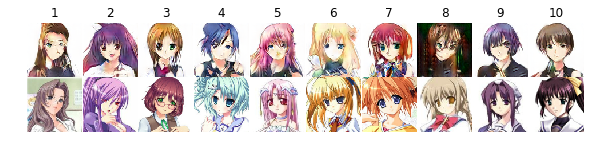

In [53]:
# for comparision between real and generated images
# Generate images from noise, using the generator network. 
cnt = 0

f, a = plt.subplots(2, 10, figsize=(10, 2))
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
for i in range(10):
    # Noise input.
    
    
    batch_x, batch_y = data_X.next_batch(batch_size)
    
    batch_x = batch_x + mean_rgb
    
    t_logit = sess.run([true_logit], feed_dict={dis_input: batch_x, lab_input: batch_y})
    t_logit = np.reshape(t_logit, (batch_size, ))
    # print (t_logit)
    
    # print (f_logit.shape)
    for j in range(1):
        # Generate image from noise. Extend to 3 channels for matplot figure.
        
        z = np.random.normal(0., 1., size=[batch_size, z_dim - f_dim])
        
        batch_y_repeat = np.zeros((batch_size, f_dim))
        for k in range(batch_size):
            batch_y_repeat[k] = batch_y[j]
        
        g, f_logit = sess.run([fake_input, fake_logit], feed_dict={gen_input: z, lab_input: batch_y_repeat})
    
        g = g + mean_rgb
        g[g > 1.] = 1.
        g[g < 0.] = 0.
        
        
        f_logit = np.reshape(f_logit, (batch_size, ))
        index = np.argmax(f_logit)
        
        cv2.imwrite('../result/{}.jpg'.format(str(cnt).zfill(3)), g[index] * 255)
        
        img = g[index]
        
        img = np.uint8(img * 255);
        
        a[j][i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        a[j][i].axis('off')
        a[j][i].title.set_text(i+1)
        img = batch_x[j]
        
        img = np.uint8(img * 255);
        
        a[j + 1][i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        a[j + 1][i].axis('off')
        cnt += 1
        
        for k in range(batch_y.shape[1]):
            if batch_y[j][k] == 1:
                print (label_dict[k], end = ', ')
        #print (f_logit[index], cnt - 1)
        print (f_logit[index],t_logit[j], cnt)
f.show()
plt.draw()
pylab.savefig('../result/experi1.png')

long_hair, blush, smile, blue_eyes, pink_hair, simple_background, 153.22379 80.58883 1
long_hair, blush, smile, blue_eyes, pink_hair, simple_background, 153.68011 80.58883 2
long_hair, blush, smile, blue_eyes, pink_hair, simple_background, 152.0386 80.58883 3
long_hair, blush, smile, blue_eyes, pink_hair, simple_background, 154.01901 80.58883 4
long_hair, blush, smile, blue_eyes, pink_hair, simple_background, 150.62376 80.58883 5
long_hair, blush, smile, blue_eyes, pink_hair, simple_background, 153.38037 80.58883 6
long_hair, blush, smile, blue_eyes, pink_hair, simple_background, 154.65369 80.58883 7
long_hair, blush, smile, blue_eyes, pink_hair, simple_background, 154.64487 80.58883 8
long_hair, blush, smile, blue_eyes, pink_hair, simple_background, 152.07996 80.58883 9
long_hair, blush, smile, blue_eyes, pink_hair, simple_background, 150.969 80.58883 10
long_hair, blush, smile, blue_eyes, pink_hair, simple_background, 152.6979 80.58883 11
long_hair, blush, smile, blue_eyes, pink_hair

/home/shared/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


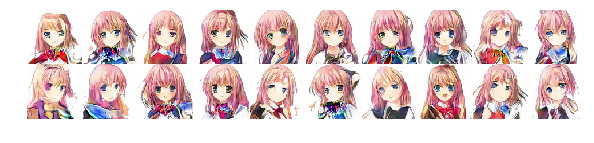

In [65]:
# for accuracy
cnt = 0

f, a = plt.subplots(2, 10, figsize=(10, 2))
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
#for i in range(10):
    # Noise input.
    
    
batch_x, batch_y = data_X.next_batch(batch_size)

batch_x = batch_x + mean_rgb

t_logit = sess.run([true_logit], feed_dict={dis_input: batch_x, lab_input: batch_y})
t_logit = np.reshape(t_logit, (batch_size, ))
# print (t_logit)

# print (f_logit.shape)
for j in range(20):
    # Generate image from noise. Extend to 3 channels for matplot figure.

    z = np.random.normal(0., 1., size=[batch_size, z_dim - f_dim])

    batch_y_repeat = np.zeros((batch_size, f_dim))
    for k in range(batch_size):
        batch_y_repeat[k] = batch_y[0]

    g, f_logit = sess.run([fake_input, fake_logit], feed_dict={gen_input: z, lab_input: batch_y_repeat})

    g = g + mean_rgb
    g[g > 1.] = 1.
    g[g < 0.] = 0.


    f_logit = np.reshape(f_logit, (batch_size, ))
    index = np.argmax(f_logit)

    #cv2.imwrite('../result/acc{}.jpg'.format(str(cnt).zfill(3)), g[index] * 255)

    img = g[index]

    img = np.uint8(img * 255);

    a[j//10][j%10].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    a[j//10][j%10].axis('off')
    #a[j][i].title.set_text(i+1)
    cnt += 1

    for k in range(batch_y.shape[1]):
        if batch_y[0][k] == 1:
            print (label_dict[k], end = ', ')
    #print (f_logit[index], cnt - 1)
    print (f_logit[index],t_logit[0], cnt)
f.show()
plt.draw()
pylab.savefig('../result/experi_acc.png')

long_hair, red_eyes, ribbon, twintails, blue_hair, 

/home/shared/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


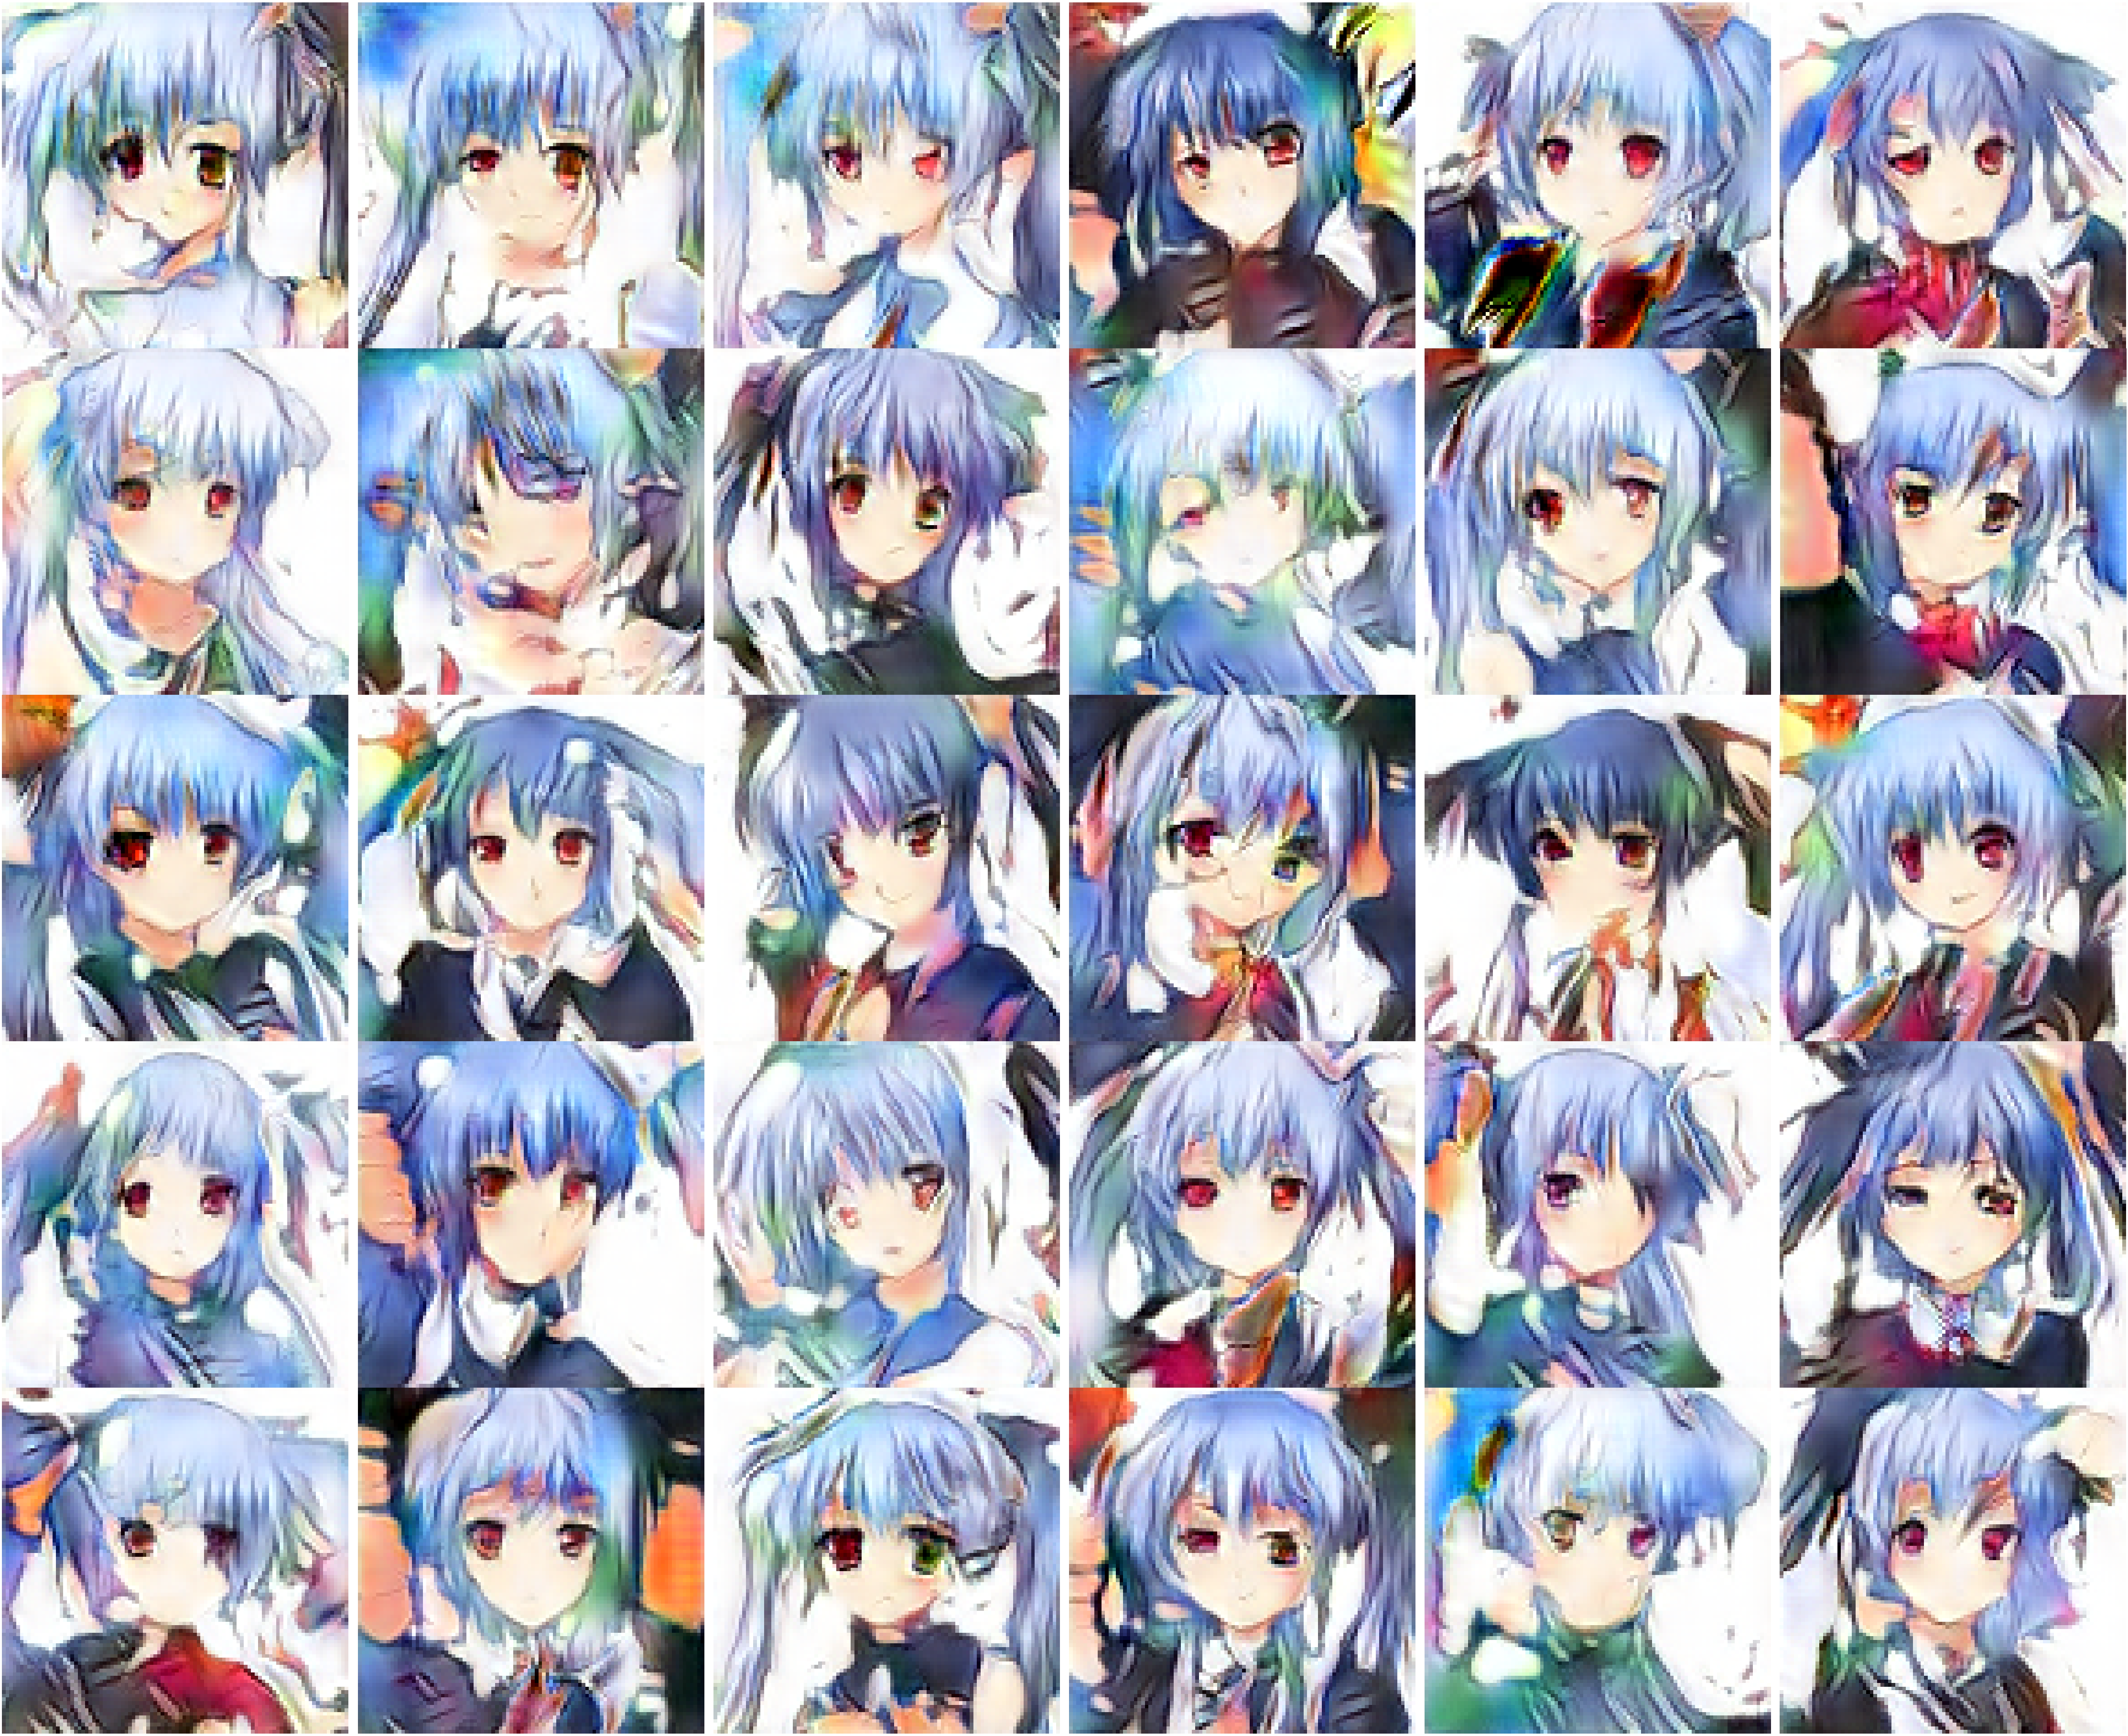

In [108]:
# for accuracy,
cnt = 0
f, a = plt.subplots(5, 6, figsize=(96*6, 96*5), dpi=10)
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
#for i in range(10):
    # Noise input.
    
    
batch_x, batch_y = data_X.next_batch(batch_size)

batch_x = batch_x + mean_rgb

t_logit = sess.run([true_logit], feed_dict={dis_input: batch_x, lab_input: batch_y})
t_logit = np.reshape(t_logit, (batch_size, ))
# print (t_logit)

# print (f_logit.shape)
for j in range(30):
    # Generate image from noise. Extend to 3 channels for matplot figure.

    z = np.random.normal(0., 1., size=[batch_size, z_dim - f_dim])

    batch_y_repeat = np.zeros((batch_size, f_dim))
    for k in range(batch_size):
        batch_y_repeat[k] = batch_y[0]

    g, f_logit = sess.run([fake_input, fake_logit], feed_dict={gen_input: z, lab_input: batch_y_repeat})

    g = g + mean_rgb
    g[g > 1.] = 1.
    g[g < 0.] = 0.


    f_logit = np.reshape(f_logit, (batch_size, ))
    index = np.argmax(f_logit)

    #cv2.imwrite('../result/acc{}.jpg'.format(str(cnt).zfill(3)), g[index] * 255)

    img = g[index]

    img = np.uint8(img * 255);

    a[j//6][j%6].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    a[j//6][j%6].axis('off')
    #a[j][i].title.set_text(i+1)
    cnt += 1

for k in range(batch_y.shape[1]):
    if batch_y[0][k] == 1:
        print (label_dict[k], end = ', ')
    #print (f_logit[index], cnt - 1)
    #print (f_logit[index],t_logit[0], cnt)
f.show()
plt.draw()
pylab.savefig('../result/experi_acc2.png',dpi=10)

['orange_hair', 'yellow_eyes', 'smile', 'blush']


/home/shared/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


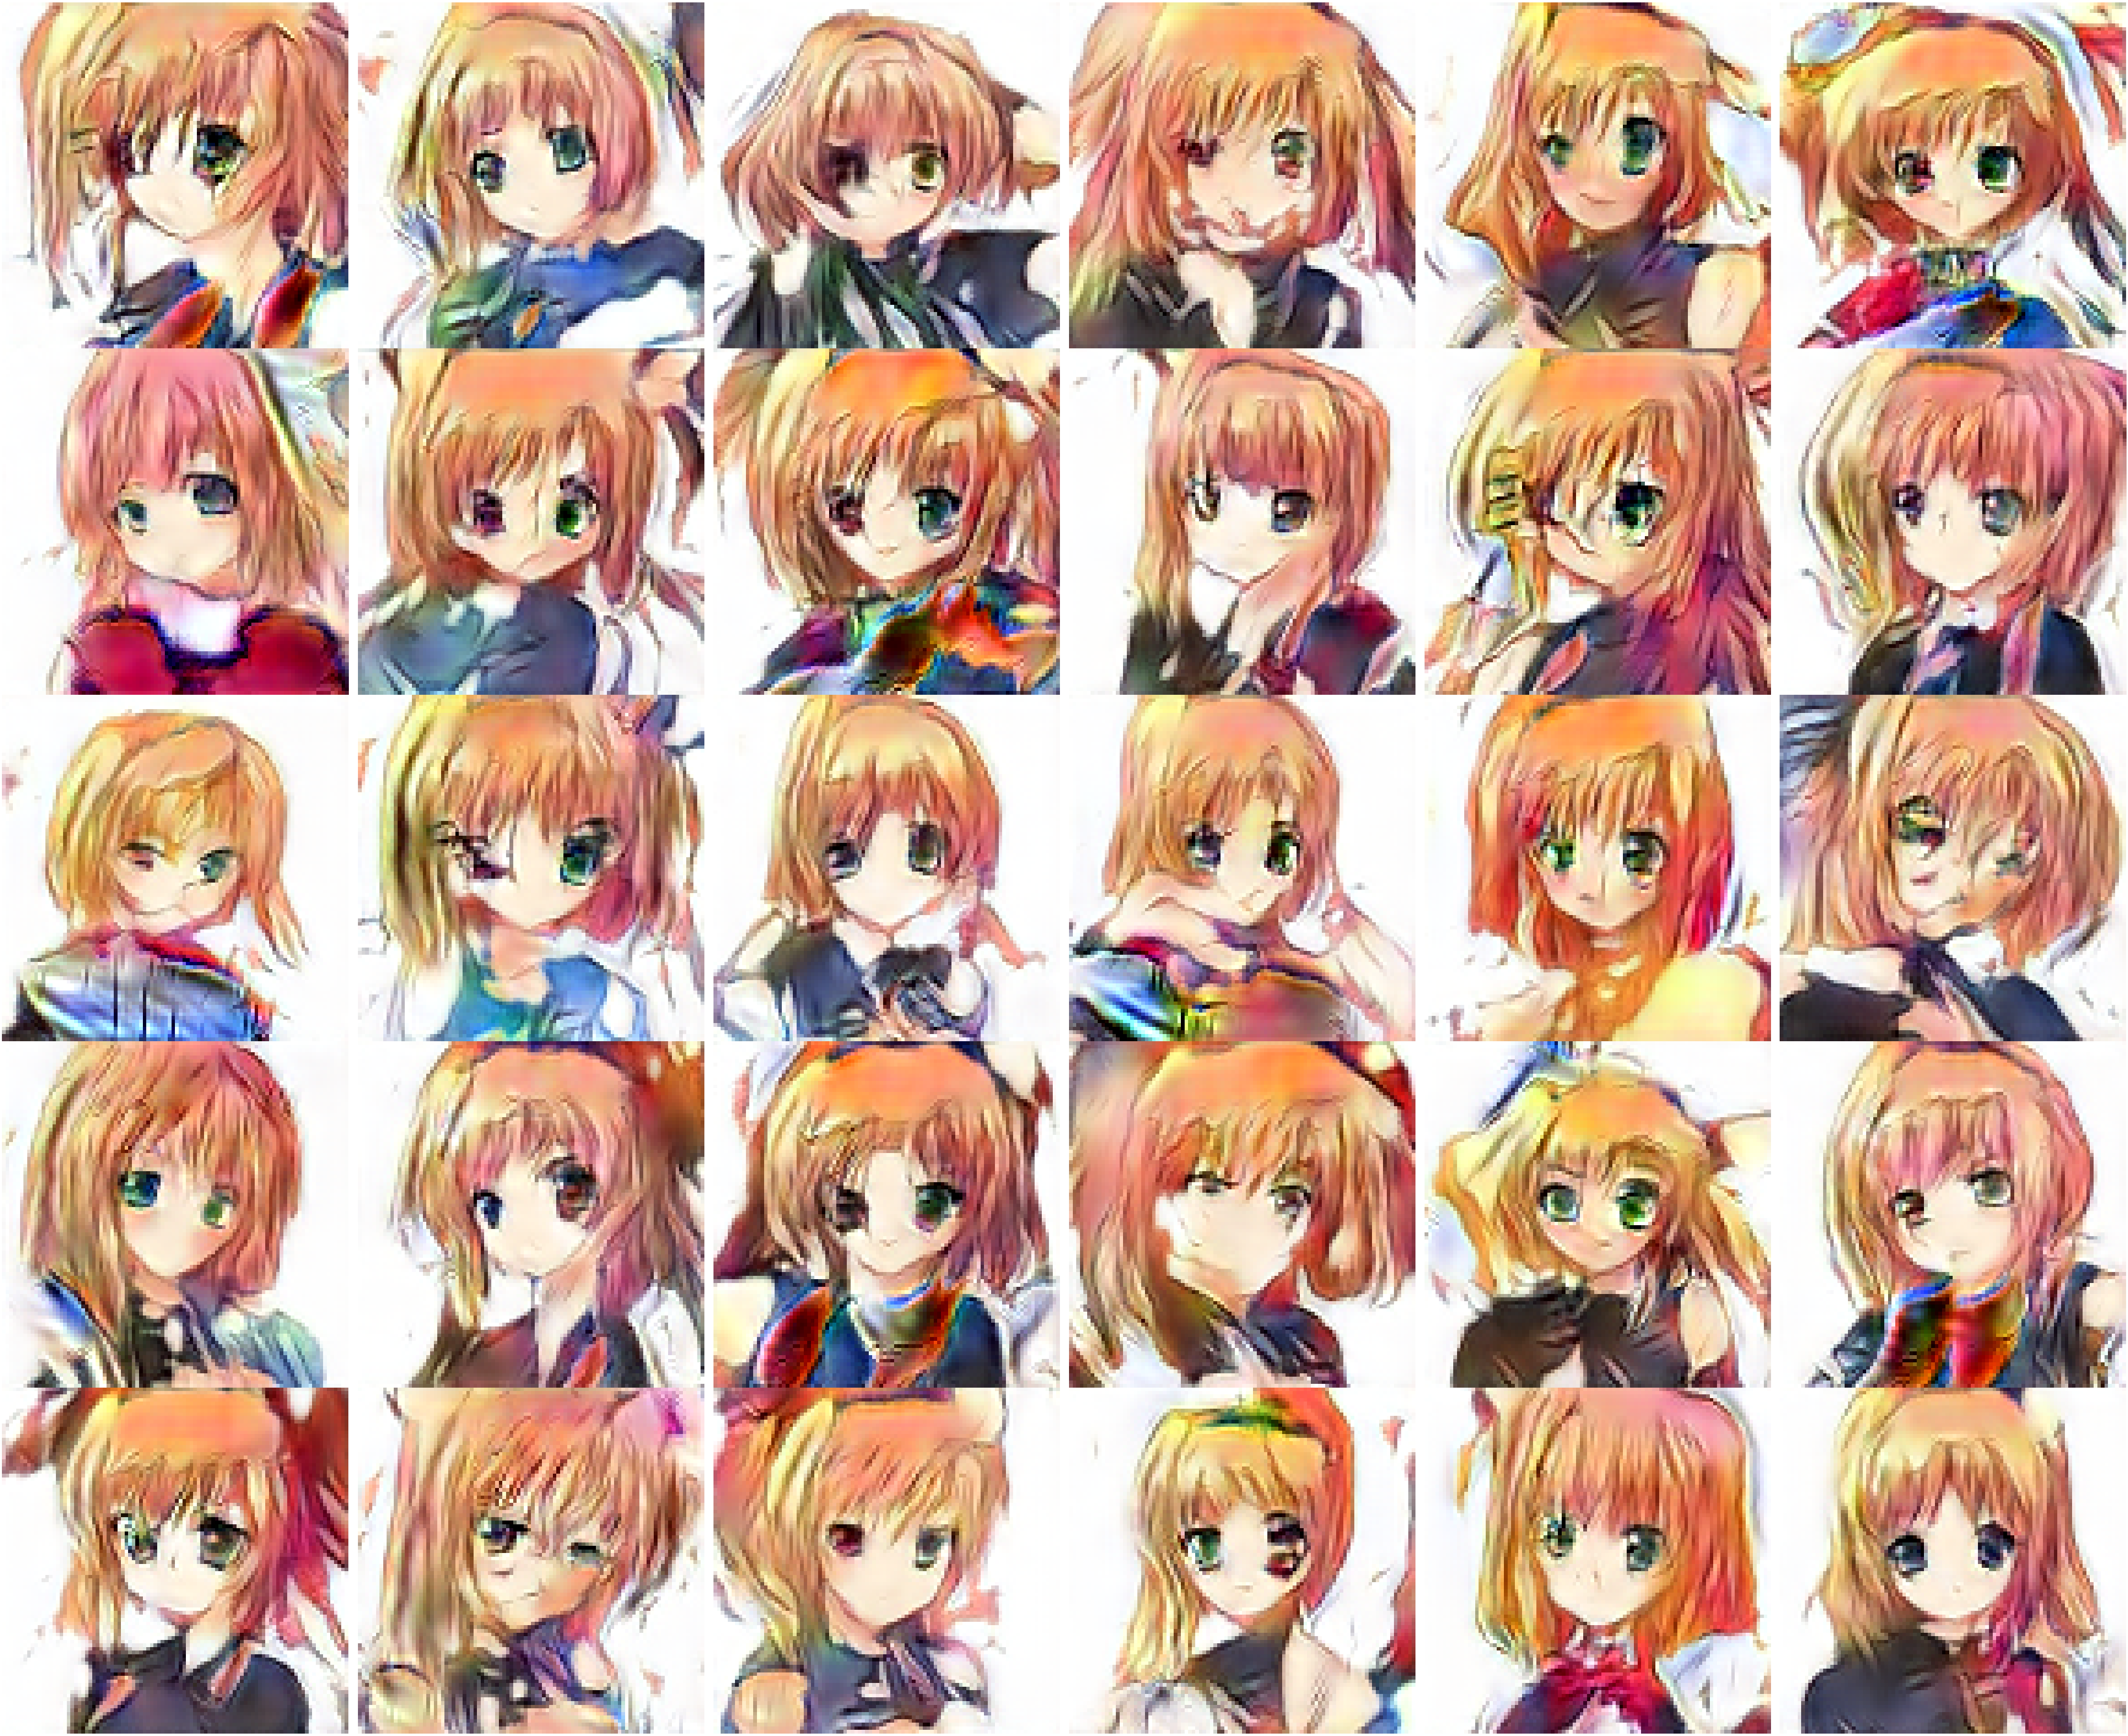

In [118]:
# for accuracy. Not common label
rev_label_dict = {'long_hair': 0, 'short_hair': 1, 'blush': 2, 'smile': 3, 'blonde_hair': 4, 'blue_eyes': 5, 'brown_hair': 6, 'open_mouth': 7, 'hat': 8, 'red_eyes': 9, 'black_hair': 10, 'ribbon': 11, 'twintails': 12, 'brown_eyes': 13, 'blue_hair': 14, 'green_eyes': 15, 'purple_eyes': 16, 'pink_hair': 17, 'purple_hair': 18, 'closed_eyes': 19, 'ponytail': 20, 'green_hair': 21, 'simple_background': 22, 'red_hair': 23, 'yellow_eyes': 24, 'very_long_hair': 25, 'glasses': 26, 'silver_hair': 27, 'one_eye_closed': 28, 'ahoge': 29, 'male': 30, 'white_hair': 31, 'earrings': 32, 'tongue': 33, 'pink_eyes': 34, 'aqua_eyes': 35, 'black_eyes': 36, 'orange_hair': 37, 'aqua_hair': 38, 'grin': 39, 'multicolored_hair': 40, 'dark_skin': 41, 'tongue_out': 42, 'grey_hair': 43, 'drill_hair': 44, 'short_twintails': 45, 'orange_eyes': 46, 'facial_hair': 47, 'grey_eyes': 48, 'two-tone_hair': 49, 'tan': 50}
condition = ['orange_hair', 'yellow_eyes','smile','blush']
print(condition)
con_label = [0] * 51
for k in rev_label_dict:
    if (k in condition):
        con_label[rev_label_dict[k]] = 1

f, a = plt.subplots(5, 6,  figsize=(96*6, 96*5), dpi=10)
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')

for j in range(30):
    # Generate image from noise. Extend to 3 channels for matplot figure.

    z = np.random.normal(0., 1., size=[batch_size*2, z_dim - f_dim])

    batch_y_repeat = np.zeros((batch_size*2, f_dim))
    for k in range(batch_size*2):
        batch_y_repeat[k] = con_label

    g, f_logit = sess.run([fake_input, fake_logit], feed_dict={gen_input: z, lab_input: batch_y_repeat})

    g = g + mean_rgb
    g[g > 1.] = 1.
    g[g < 0.] = 0.


    f_logit = np.reshape(f_logit, (batch_size*2, ))
    index = np.argmax(f_logit)

    #cv2.imwrite('../result/acc{}.jpg'.format(str(cnt).zfill(3)), g[index] * 255)

    img = g[index]

    img = np.uint8(img * 255);

    a[j//6][j%6].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    a[j//6][j%6].axis('off')
    #a[j][i].title.set_text(i+1)
    cnt += 1

f.show()
plt.draw()
pylab.savefig('../result/experi_acc3.png',dpi=10)

['blue_eyes', 'brown_hair']


/home/shared/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


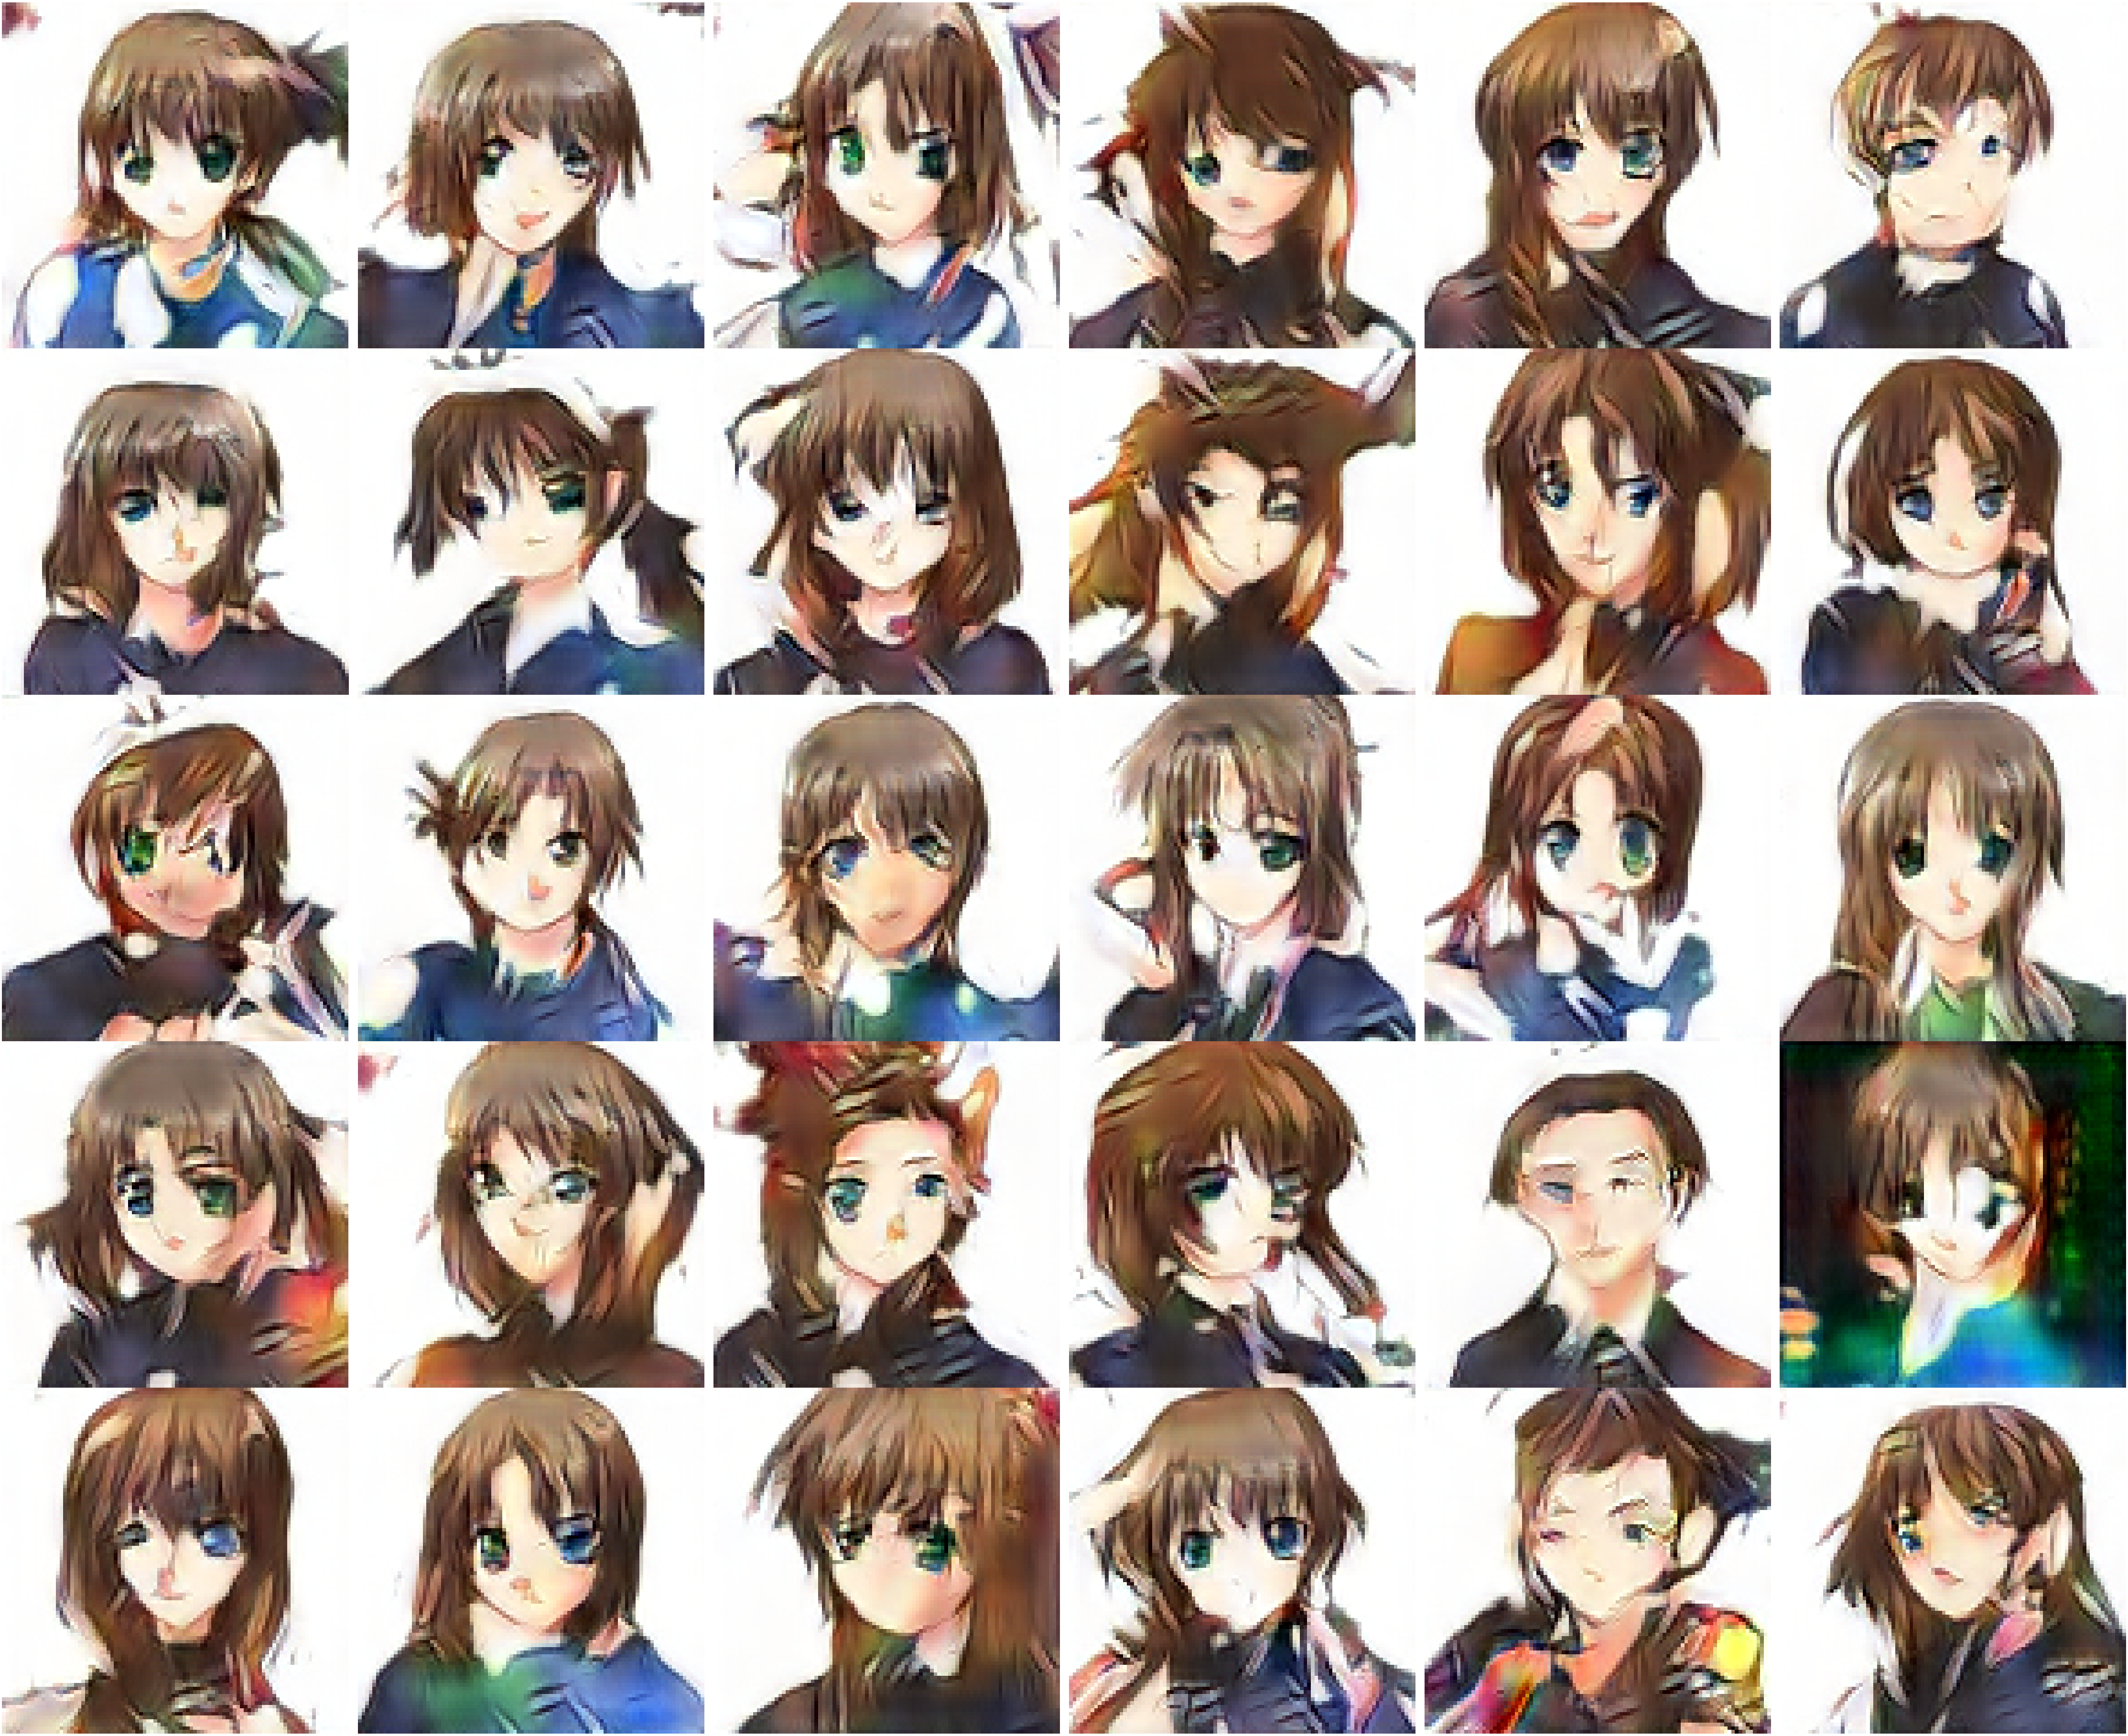

In [123]:
# for accuracy. common label
rev_label_dict = {'long_hair': 0, 'short_hair': 1, 'blush': 2, 'smile': 3, 'blonde_hair': 4, 'blue_eyes': 5, 'brown_hair': 6, 'open_mouth': 7, 'hat': 8, 'red_eyes': 9, 'black_hair': 10, 'ribbon': 11, 'twintails': 12, 'brown_eyes': 13, 'blue_hair': 14, 'green_eyes': 15, 'purple_eyes': 16, 'pink_hair': 17, 'purple_hair': 18, 'closed_eyes': 19, 'ponytail': 20, 'green_hair': 21, 'simple_background': 22, 'red_hair': 23, 'yellow_eyes': 24, 'very_long_hair': 25, 'glasses': 26, 'silver_hair': 27, 'one_eye_closed': 28, 'ahoge': 29, 'male': 30, 'white_hair': 31, 'earrings': 32, 'tongue': 33, 'pink_eyes': 34, 'aqua_eyes': 35, 'black_eyes': 36, 'orange_hair': 37, 'aqua_hair': 38, 'grin': 39, 'multicolored_hair': 40, 'dark_skin': 41, 'tongue_out': 42, 'grey_hair': 43, 'drill_hair': 44, 'short_twintails': 45, 'orange_eyes': 46, 'facial_hair': 47, 'grey_eyes': 48, 'two-tone_hair': 49, 'tan': 50}
condition = ['blue_eyes','brown_hair']
print(condition)
con_label = [0] * 51
for k in rev_label_dict:
    if (k in condition):
        con_label[rev_label_dict[k]] = 1

f, a = plt.subplots(5, 6,  figsize=(96*6, 96*5), dpi=10)
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
for j in range(30):
    # Generate image from noise. Extend to 3 channels for matplot figure.

    z = np.random.normal(0., 1., size=[batch_size*4, z_dim - f_dim])

    batch_y_repeat = np.zeros((batch_size*4, f_dim))
    for k in range(batch_size*4):
        batch_y_repeat[k] = con_label

    g, f_logit = sess.run([fake_input, fake_logit], feed_dict={gen_input: z, lab_input: batch_y_repeat})

    g = g + mean_rgb
    g[g > 1.] = 1.
    g[g < 0.] = 0.


    f_logit = np.reshape(f_logit, (batch_size*4, ))
    index = np.argmax(f_logit)

    #cv2.imwrite('../result/acc{}.jpg'.format(str(cnt).zfill(3)), g[index] * 255)

    img = g[index]

    img = np.uint8(img * 255);

    a[j//6][j%6].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    a[j//6][j%6].axis('off')
    #a[j][i].title.set_text(i+1)
    cnt += 1

f.show()
plt.draw()
pylab.savefig('../result/experi_acc4.png',dpi=10)

long_hair, blush, smile, black_hair, brown_eyes, -17.035751 -112.137054 1
short_hair, green_eyes, red_hair, 75.04319 -0.9069443 2
short_hair, smile, brown_hair, brown_eyes, 79.90689 -26.700462 3
long_hair, green_hair, yellow_eyes, 13.796867 -73.92348 4
long_hair, smile, blonde_hair, blue_eyes, 182.57455 116.1758 5
long_hair, blush, green_eyes, green_hair, 21.3074 -60.91815 6
short_hair, blue_eyes, brown_hair, simple_background, 63.955032 -39.45938 7
short_hair, blush, brown_hair, brown_eyes, simple_background, 65.29696 -56.13762 8
long_hair, purple_eyes, purple_hair, 4.3304253 -85.49687 9
short_hair, brown_hair, green_eyes, simple_background, 66.63048 -18.632683 10


/home/shared/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


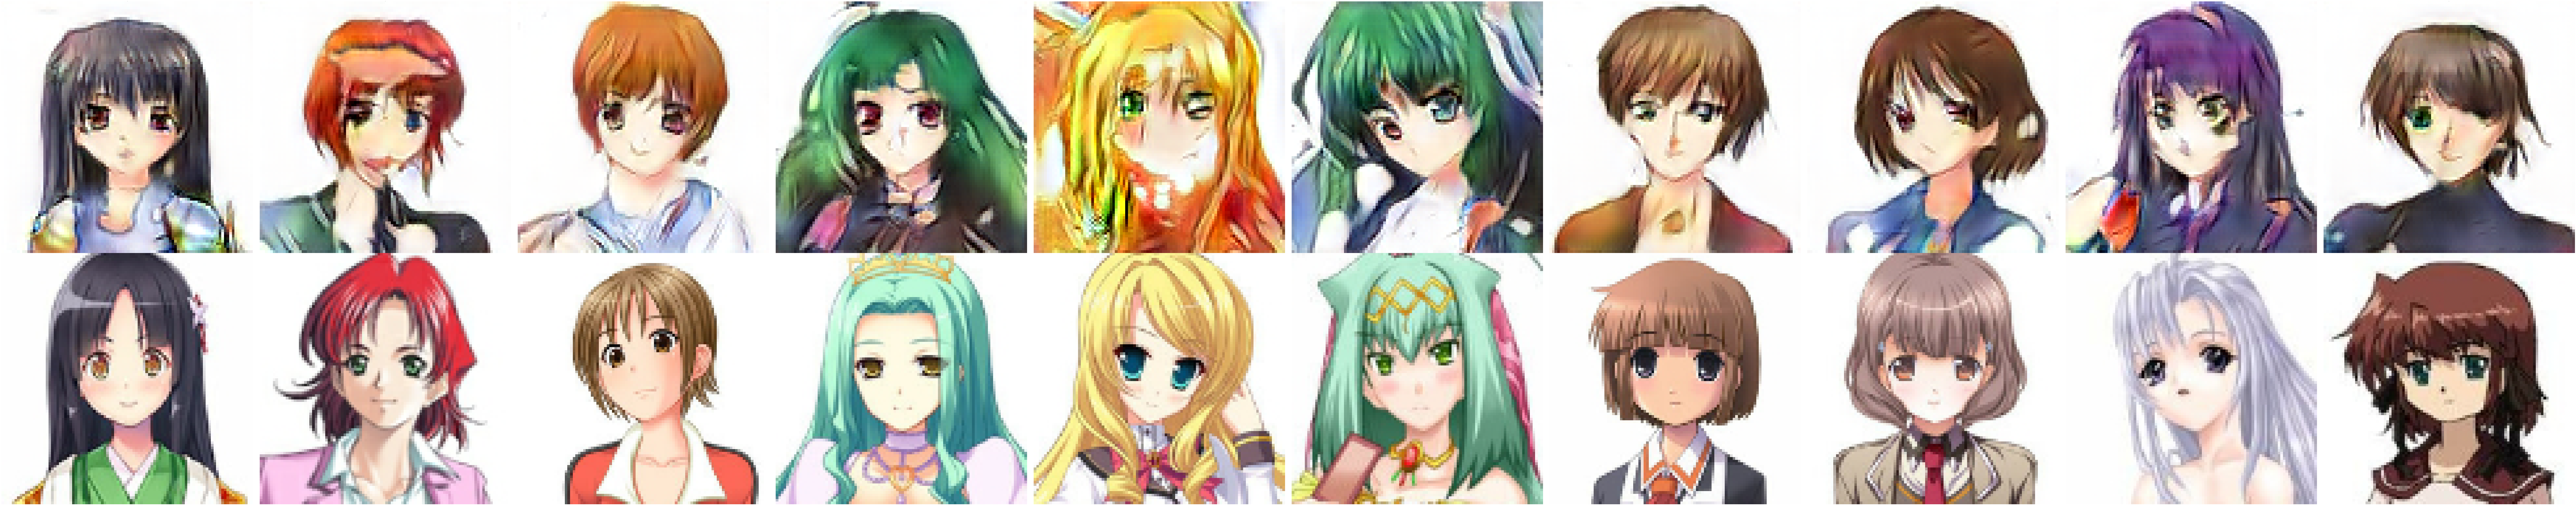

In [17]:
# for comparision between real and generated images
# Generate images from noise, using the generator network. 
cnt = 0

f, a = plt.subplots(2, 10,figsize=(96*10, 96*2), dpi=10)
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
for i in range(10):
    # Noise input.
    
    
    batch_x, batch_y = data_X.next_batch(batch_size)
    
    batch_x = batch_x + mean_rgb
    
    t_logit = sess.run([true_logit], feed_dict={dis_input: batch_x, lab_input: batch_y})
    t_logit = np.reshape(t_logit, (batch_size, ))
    # print (t_logit)
    
    # print (f_logit.shape)
    for j in range(1):
        # Generate image from noise. Extend to 3 channels for matplot figure.
        
        z = np.random.normal(0., 1., size=[batch_size, z_dim - f_dim])
        
        batch_y_repeat = np.zeros((batch_size, f_dim))
        for k in range(batch_size):
            batch_y_repeat[k] = batch_y[j]
        
        g, f_logit = sess.run([fake_input, fake_logit], feed_dict={gen_input: z, lab_input: batch_y_repeat})
    
        g = g + mean_rgb
        g[g > 1.] = 1.
        g[g < 0.] = 0.
        
        
        f_logit = np.reshape(f_logit, (batch_size, ))
        index = np.argmax(f_logit)
        
        cv2.imwrite('../result/{}.jpg'.format(str(cnt).zfill(3)), g[index] * 255)
        
        img = g[index]
        
        img = np.uint8(img * 255);
        
        a[j][i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        a[j][i].axis('off')
        a[j][i].title.set_text(i+1)
        img = batch_x[j]
        
        img = np.uint8(img * 255);
        
        a[j + 1][i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        a[j + 1][i].axis('off')
        cnt += 1
        
        for k in range(batch_y.shape[1]):
            if batch_y[j][k] == 1:
                print (label_dict[k], end = ', ')
        #print (f_logit[index], cnt - 1)
        print (f_logit[index],t_logit[j], cnt)
f.show()
plt.draw()
pylab.savefig('../result/experi5.png',dpi=10)